### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import cv2
from tqdm.notebook import tqdm
import os
from pathlib import Path

import torch
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models import resnet18, efficientnet_b0, mobilenet_v2, efficientnet_v2_s
from sklearn.metrics import f1_score

from albumentations import Compose, Normalize, Resize
from torch.autograd import Variable

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10
SEED= 42
np.random.seed(SEED)
torch.manual_seed(SEED)
plt.ion()

In [4]:
repository_root = Path.cwd().parent.parent.parent.parent

root_dir = repository_root / "myanmar-weather-forecasting" / "data" / "traffic" / "singapore-traffic-density"

save_dir= repository_root / "myanmar-weather-forecasting" / "src" / "traffic" / "models" / "models_runs"


configs

In [5]:
Res18_config= {'network': 'resnet18', 'num_classes': 5} 
ENb0_config= {'network': 'efficientnet-b0', 'num_classes': 5}
MNv2_config= {'network': 'mobilenet_v2', 'num_classes': 5}
ENv2_config= {'network': 'efficientnet_v2_s', 'num_classes': 5}

# NUM_WORKERS = 0 > https://github.com/pytorch/pytorch/issues/13246
training_config= {'BATCH_SIZE': 64, 'NUM_WORKERS': 0, 'WARM_UP_EPOCHS': 10, 'WARM_UP_LR': 1e-4, 
                  'FINE_TUNE_EPOCHS': 100, 'FINE_TUNE_LR': 1e-6}

### showing some insights

In [6]:
# utils functions for visualization
def load_image(img_path: Path):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(np.array(images))
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11).cpu() # if not on GPU remove .cpu()
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

In [7]:
examples= root_dir/"train"/"High"

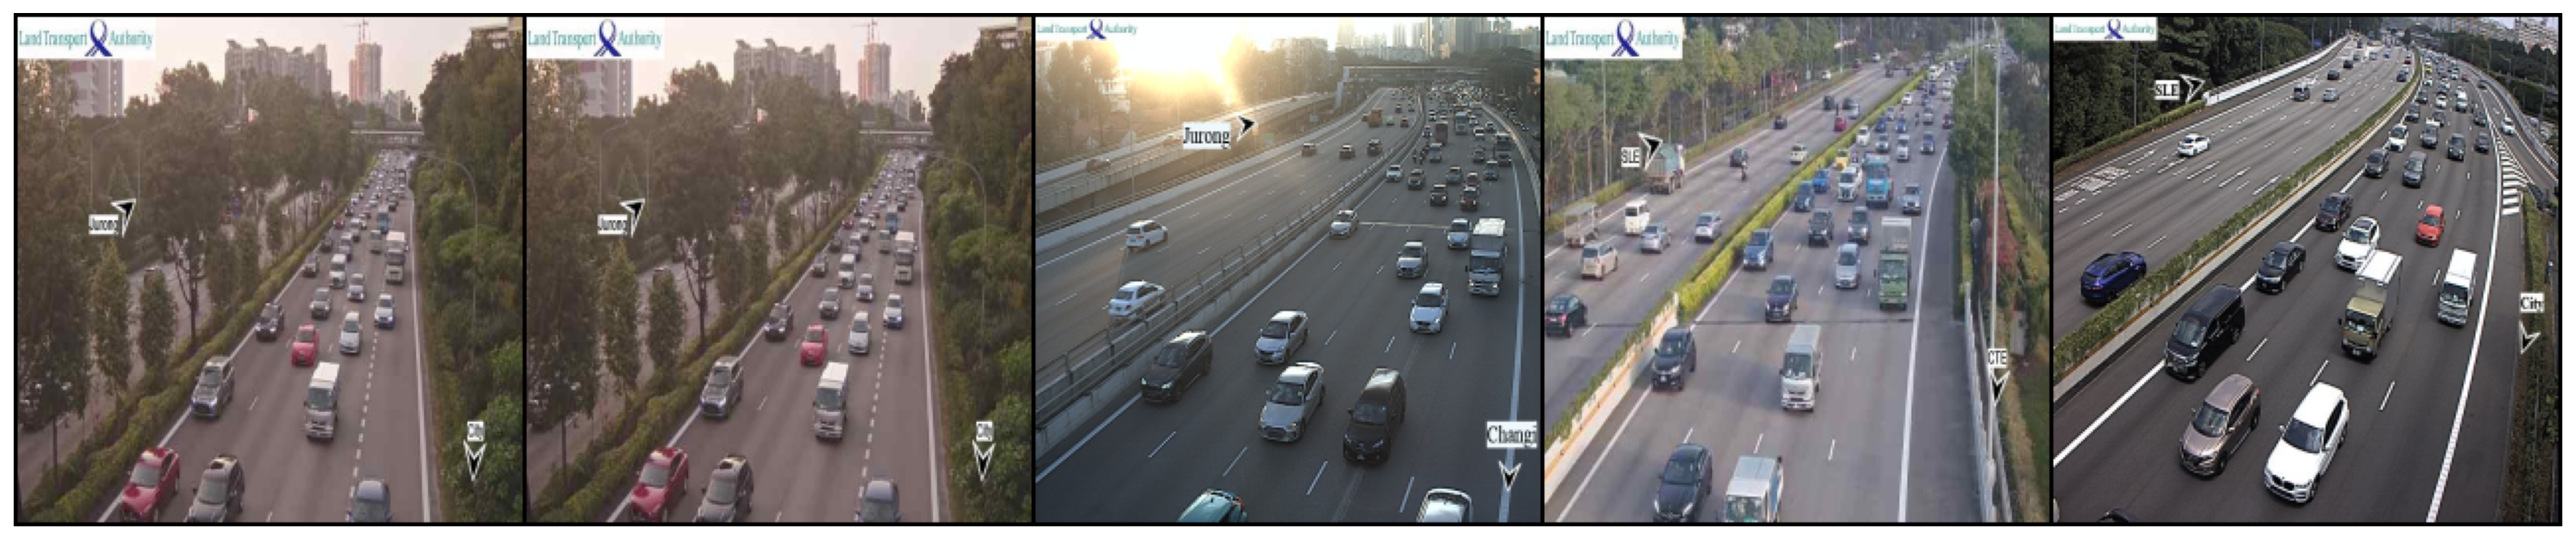

In [8]:
img_paths = list(Path(examples).glob("*.jpg"))[:5]
show_grid(img_paths)

In [9]:
df= pd.read_csv(root_dir/"singapore-traffic-density.csv")

In [10]:
# windows need full path, might be modified later, even better use ImageFolder
df.img_path= df.img_path.apply(lambda x: os.path.join(repository_root, x))

In [11]:
# a bit of imbalence here
df[df['split']=='train'].groupby(['label']).count()

img_path  split
label                       
Empty            1186   1186
High              378    378
Low               936    936
Medium            688    688
Traffic Jam       190    190

In [12]:
df[df['split']=='val'].groupby(['label']).count()

img_path  split
label                       
Empty              64     64
High               64     64
Low                64     64
Medium             64     64
Traffic Jam        64     64

In [13]:
df[df['split']=='test'].groupby(['label']).count()


img_path  split
label                       
Empty             120    120
High               38     38
Low                94     94
Medium             70     70
Traffic Jam        18     18

### building dataset

In [14]:
class TrafficDataset(Dataset):
    def __init__(self, df, preprocess=None):
        self.img_dirs = df.img_path.to_numpy()
        self.label = df.label.to_numpy()
        self.classes, self.label_encoder= self.process_label(df)
        self.preprocess = preprocess

    def __len__(self):
        return len(self.img_dirs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx= idx.tolist()

        img_path= self.img_dirs[idx]
        label= self.label[idx]

        img= cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.preprocess is not None:
            img = self.preprocess(image=img)
        
        return {
            'img': img,
            'label': torch.tensor(self.label_encoder[label], dtype=torch.long)
        }
    
    def process_label(self, df):
        classes= df.label.unique().tolist()
        label_encoder= {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, label_encoder
        

In [15]:
# a lot of improvements can be made here
preprocess= Compose([
    Resize(224, 224),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1)
])

In [16]:
df_train = df[df['split'] == 'train']
df_val = df[df['split'] == 'val']
df_test = df[df['split'] == 'test']

In [17]:
train_dataset = TrafficDataset(
    df=df_train,
    preprocess=preprocess
)
val_dataset = TrafficDataset(
    df=df_val,
    preprocess=preprocess
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=training_config['BATCH_SIZE'],
    shuffle=True,
    num_workers=training_config['NUM_WORKERS'],
    generator=torch.Generator(device='cuda')
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=training_config['BATCH_SIZE'],
    shuffle=False,
    num_workers=training_config['NUM_WORKERS'],
    generator=torch.Generator(device='cuda')
)
test_dataset = TrafficDataset(
    df=df_test,
    preprocess=preprocess
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=training_config['BATCH_SIZE'], # feel free to set it to 1 if used for inference
    shuffle=False,
    num_workers=training_config['NUM_WORKERS'],
    generator=torch.Generator(device='cuda')
)

In [18]:
# everything worked properly 
for batch in tqdm(train_dataloader):
    img_batch = batch['img']['image']
    img_batch= img_batch.permute(0, 3, 1, 2)
    label_batch = batch['label']

    print(type(img_batch), img_batch.shape)
    print(type(label_batch), label_batch.shape)

    break

  0%|          | 0/53 [00:00<?, ?it/s]

<class 'torch.Tensor'> torch.Size([64, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([64])


### Training Utils

In [19]:
def calculate_f1(y_true, y_pred, average='macro'):
    return f1_score(y_true, y_pred, average=average)

In [20]:
class FocalLoss(nn.Module):
    """
    focal loss implementation by: https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py
    this loss is good with class imbalance, although cross entropy almost has the same effect as focal loss in this dataset
    """
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

### Building Model

In [21]:
def TrafficClassifier(cfg, load_path=None):
    if load_path:
        try:
            print('[*] Attempting to load model from:', load_path)
            model = _TrafficClassifier(cfg)
            model.load_state_dict(torch.load(load_path)['state_dict'])
        except: 
            print('[*] Model does not exist or is corrupted. Creating new model...')
            return _TrafficClassifier(cfg)

        # check whether `model` is an _TrafficClassifier instance
        if model.__class__.__name__ == '_TrafficClassifier':
            return model
        else:
            raise ValueError('The loaded tensor is not an instance of _TrafficClassifier.')
    else:
        print('[*] Creating model...')
        return _TrafficClassifier(cfg)

class _TrafficClassifier(nn.Module):
    def __init__(self, cfg):
        super(_TrafficClassifier, self).__init__()
        self.num_classes= cfg['num_classes']
        self.network= cfg['network']

        if cfg['network'] == "resnet18":
           self.initialize_resnet18()

        if cfg['network'] == "efficientnet-b0":
            self.initialize_enb0()
        
        if cfg['network'] == "mobilenet_v2":
            self.initialize_mnv2()

        if cfg['network'] == "efficientnet_v2_s":
            self.initialize_en_v2()

    def forward(self, x):
        return self.encoder(x)
    
    def freeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def freeze_middle_layers(self):
        self.freeze_all_layers()
        if self.network == "resnet18":
            for param in self.encoder.conv1.parameters():
                param.requires_grad = True
                
            for param in self.encoder.fc.parameters():
                param.requires_grad = True

        elif self.network == "efficientnet-b0" or self.network == "mobilenet_v2" or self.network == "efficientnet_v2_s":
            for param in self.encoder.features[0][0].parameters():
                param.requires_grad = True

            for param in self.encoder.classifier.parameters():
                param.requires_grad = True

        else:
            raise ValueError("Something went wrong! Model is not defined")

    def unfreeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = True

    def initialize_resnet18(self):
        print('[*] Initializing new resnet18 network...')
        # we need to modify the input (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
        # and output layers (fc): Linear(in_features=512, out_features=1000, bias=True)
        self.encoder = resnet18(pretrained=True).to(device)

        # modifying output layer.
        self.encoder.fc = nn.Linear(512, self.num_classes, bias= True)

    def initialize_enb0(self):
        print('[*] Initializing new efficientnet-b0 network...')
        self.encoder = efficientnet_b0(pretrained=True).to(device)
        

        self.encoder.classifier[1]= nn.Linear(1280, self.num_classes, bias= True)

    def initialize_mnv2(self):
        print('[*] Initializing new mobilenet_v2 network...')
        self.encoder = mobilenet_v2(pretrained=True).to(device)
        

        self.encoder.classifier[1]= nn.Linear(1280, self.num_classes, bias= True)

    def initialize_en_v2(self):
        print('[*] Initializing new efficientnet-v2 network...')
        self.encoder = efficientnet_v2_s(pretrained=True).to(device)


        self.encoder.classifier[1]= nn.Linear(1280, self.num_classes, bias= True)
  
    def _get_index_of_matched_value(self, dictionary, value):

        for idx, val in dictionary.items():
            if val == value:
                return idx

        return None
    
    def test_model(self, test_loader):
        self.eval()
        criterion= FocalLoss()
        with torch.no_grad():            
            test_batch_losses = []
            test_pbar = tqdm(test_loader)
            test_pbar.desc = 'Testing'

            all_labels = []
            all_preds = []
            all_out= []

            for i_batch, sample_batched in enumerate(test_pbar):
                # Make prediction.
                y_pred = self.encoder(sample_batched['img']['image'].permute(0, 3, 1, 2))
                out= torch.argmax(y_pred, dim= 1)

                
                all_labels.extend(sample_batched['label'].tolist())
                all_preds.extend(y_pred.cpu().detach().numpy().tolist()) # batch x number_of_cls
                all_out.extend(out.tolist())

                # Compute val loss.
                test_loss = criterion(y_pred, sample_batched['label'].view(-1, 1))
                test_batch_losses.append(test_loss.item())

                # Display some information in progress-bar.
                test_pbar.set_postfix({
                    'test_loss': test_batch_losses[-1]
                })

            test_loglosses = criterion(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))
            test_f1_scores = calculate_f1(all_out, all_labels)

            test_losses = np.array(test_batch_losses).mean()
        
        return test_loglosses, test_f1_scores, test_losses

    def inference(self, img_path):
        self.eval()
        img= cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img= preprocess(image= img) # resizing is important
        _img= np.expand_dims(img['image'], axis= 0)
        _img= np.transpose(_img, (0, 3, 1, 2))
        _img= torch.tensor(_img)
        _img.to(device)
        with torch.no_grad():
            y_pred = self.encoder(_img)
            out= torch.argmax(y_pred, dim= 1)
            
        output= self._get_index_of_matched_value(train_dataset.label_encoder, out)
        return output
        


### Modeling

In [22]:
class TrafficTrainer:
    def __init__(self, 
                 model_conf, 
                 train_dataloader,
                 val_dataloader,
                 cfg,
                 save_dir,
                 best_val_loss= 1e7,
                 best_val_logloss= 1e7,
                 save_the_best_on= 'val_logloss'):
        
        self.model_conf= model_conf
        self.model= TrafficClassifier(model_conf)
        self.cfg= cfg
        self.save_dir= save_dir
        self.model_path= os.path.join(self.save_dir, model_conf['network'])
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)
        self.train_dataloader= train_dataloader
        self.val_dataloader= val_dataloader
        self.best_val_loss= best_val_loss
        self.best_val_logloss= best_val_logloss
        self.save_the_best_on= save_the_best_on
        self.losses = np.zeros(cfg['WARM_UP_EPOCHS'] + cfg['FINE_TUNE_EPOCHS'])
        self.val_losses = np.zeros(cfg['WARM_UP_EPOCHS'] + cfg['FINE_TUNE_EPOCHS'])
        self.loglosses = np.zeros(cfg['WARM_UP_EPOCHS'] + cfg['FINE_TUNE_EPOCHS'])
        self.val_loglosses = np.zeros(cfg['WARM_UP_EPOCHS'] + cfg['FINE_TUNE_EPOCHS'])
        self.f1_scores = np.zeros(cfg['WARM_UP_EPOCHS'] + cfg['FINE_TUNE_EPOCHS'])
        self.val_f1_scores = np.zeros(cfg['WARM_UP_EPOCHS'] + cfg['FINE_TUNE_EPOCHS'])


    def _call(self):

        losses = np.zeros(self.epochs)
        val_losses = np.zeros(self.epochs)
        loglosses = np.zeros(self.epochs)
        val_loglosses = np.zeros(self.epochs)
        f1_scores = np.zeros(self.epochs)
        val_f1_scores = np.zeros(self.epochs)
        best_model_state_dict = None
        best_optimizer_state_dict = None

        criterion = FocalLoss().to(device)
        logloss = nn.CrossEntropyLoss().to(device)

        for i in tqdm(range(self.epochs)):
            batch_losses = []
            val_batch_losses = []

            all_train_labels = []
            all_val_labels = []
            all_train_preds = []
            all_val_preds = []
            all_train_out= []
            all_val_out= []

            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    pbar = tqdm(train_dataloader)
                    pbar.desc = f'Epoch {i+1}'
                else:
                    pbar = tqdm(val_dataloader)
                    pbar.desc = 'Validating'
                    self.model.eval()

                for i_batch, sample_batched in enumerate(pbar):
                    inputs= sample_batched['img']['image'].permute(0, 3, 1, 2).to(device)
                    labels= sample_batched['label'].to(device)

                    self.optimizer.zero_grad()
                    # Make prediction.
                    with torch.set_grad_enabled(phase == 'train'):
                        y_pred = self.model(inputs)
                        out= torch.argmax(y_pred, dim= 1)


                        # Compute loss.
                        loss = criterion(y_pred, labels)

                        if phase == 'train':
                            batch_losses.append(loss.item())
                            # Zero gradients, perform a backward pass, and update the weights.
                            loss.backward()
                            self.optimizer.step()

                        else:
                            val_batch_losses.append(loss.item())



                    # Display some information in progress-bar.
                    if phase == 'train':
                        all_train_labels.extend(sample_batched['label'].tolist())
                        all_train_preds.extend(y_pred.cpu().detach().numpy().tolist())
                        all_train_out.extend(out.tolist())
                        pbar.set_postfix({
                            'loss': batch_losses[-1]
                        })
                    else:
                        all_val_labels.extend(sample_batched['label'].tolist())
                        all_val_preds.extend(y_pred.cpu().detach().numpy().tolist())
                        all_val_out.extend(out.tolist())
                        pbar.set_postfix({
                            'val_loss': val_batch_losses[-1]
                        })

            # Compute scores.
            loglosses[i] = logloss(torch.tensor(all_train_preds).to(device), torch.tensor(all_train_labels).to(device))
            f1_scores[i] = calculate_f1(all_train_out, all_train_labels)
            val_loglosses[i] = logloss(torch.tensor(all_val_preds).to(device), torch.tensor(all_val_labels).to(device))
            val_f1_scores[i] = calculate_f1(all_val_out, all_val_labels)

            # Compute batch loss (average).
            losses[i] = np.array(batch_losses).mean()   
            val_losses[i] = np.array(val_batch_losses).mean()

            print(f'loss: {losses[i]} | val loss: {val_losses[i]} | f1: {f1_scores[i]} | val f1: {val_f1_scores[i]} | log loss: {loglosses[i]} | val log loss: {val_loglosses[i]}')
            # Update the best values
            if val_losses[i] < self.best_val_loss:
                self.best_val_loss = val_losses[i]
                if self.save_the_best_on == 'val_loss':
                    print('Found a better checkpoint!')
                    best_model_state_dict = self.model.state_dict()
                    best_optimizer_state_dict = self.optimizer.state_dict()
            if val_loglosses[i] < self.best_val_logloss:
                self.best_val_logloss = val_loglosses[i]
                if self.save_the_best_on == 'val_logloss':
                    print('Found a better checkpoint!')
                    best_model_state_dict = self.model.state_dict()
                    best_optimizer_state_dict = self.optimizer.state_dict()                 

        return losses, val_losses, loglosses, val_loglosses, f1_scores, val_f1_scores, self.best_val_loss, self.best_val_logloss, best_model_state_dict, best_optimizer_state_dict

    def warmup(self):
        print("Warming Up Stage: {0}".format(self.model_conf['network']))
        self.model.freeze_middle_layers()
        self.epochs= self.cfg['WARM_UP_EPOCHS']
        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.cfg['WARM_UP_LR'])

        self.losses[:self.cfg['WARM_UP_EPOCHS']], self.val_losses[:self.cfg['WARM_UP_EPOCHS']], \
        self.loglosses[:self.cfg['WARM_UP_EPOCHS']], self.val_loglosses[:self.cfg['WARM_UP_EPOCHS']], \
        self.f1_scores[:self.cfg['WARM_UP_EPOCHS']], self.val_f1_scores[:self.cfg['WARM_UP_EPOCHS']], \
        self.best_val_loss, self.best_val_logloss, \
        self.best_model_state_dict, self.best_optimizer_state_dict \
        = self._call()

    def finetune(self):
        print("Fine-tuning Stage {0}".format(self.model_conf['network']))
        self.model.unfreeze_all_layers()
        self.epochs= self.cfg['FINE_TUNE_EPOCHS']
        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.cfg['FINE_TUNE_LR'])


        self.losses[self.cfg['WARM_UP_EPOCHS']:self.cfg['WARM_UP_EPOCHS']+self.cfg['FINE_TUNE_EPOCHS']], \
        self.val_losses[self.cfg['WARM_UP_EPOCHS']:self.cfg['WARM_UP_EPOCHS']+self.cfg['FINE_TUNE_EPOCHS']], \
        self.loglosses[self.cfg['WARM_UP_EPOCHS']:self.cfg['WARM_UP_EPOCHS']+self.cfg['FINE_TUNE_EPOCHS']], \
        self.val_loglosses[self.cfg['WARM_UP_EPOCHS']:self.cfg['WARM_UP_EPOCHS']+self.cfg['FINE_TUNE_EPOCHS']], \
        self.f1_scores[self.cfg['WARM_UP_EPOCHS']:self.cfg['WARM_UP_EPOCHS']+self.cfg['FINE_TUNE_EPOCHS']], \
        self.val_f1_scores[self.cfg['WARM_UP_EPOCHS']:self.cfg['WARM_UP_EPOCHS']+self.cfg['FINE_TUNE_EPOCHS']], \
        self.best_val_loss, self.best_val_logloss, \
        self.best_model_state_dict, self.best_optimizer_state_dict \
        = self._call()

        if self.best_model_state_dict is not None:
            state = {
                'state_dict': self.best_model_state_dict,
                'warmup_optimizer': self.best_optimizer_state_dict,
                'best_val_loss': self.best_val_loss,
                'best_val_logloss': self.best_val_logloss
            }

            torch.save(state, os.path.join(self.model_path,self.model_conf['network']+'.pth'))

    def train(self):
        # if using schedular then no need for warmup call
        self.warmup()
        self.finetune()

    
    def resume(self, model_path, config, epochs):
        self.losses = np.zeros(epochs)
        self.val_losses = np.zeros(epochs)
        self.loglosses = np.zeros(epochs)
        self.val_loglosses = np.zeros(epochs)
        self.f1_scores = np.zeros(epochs)
        self.val_f1_scores = np.zeros(epochs)
        self.epochs= epochs

        self.model= TrafficClassifier(load_path= model_path, cfg=config)
        state= torch.load(model_path)
        self.best_val_loss = state['best_val_loss']
        self.best_val_logloss = state['best_val_logloss']
        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.cfg['WARM_UP_LR'])
        self.optimizer.load_state_dict(state['warmup_optimizer'])

        self.losses, self.val_losses, self.loglosses, self.val_loglosses, self.f1_scores, self.val_f1_scores, \
        self.best_val_loss, self.best_val_logloss, \
        self.best_model_state_dict, self.best_optimizer_state_dict \
        = self._call()

        if self.best_model_state_dict is not None:
            state = {
                'state_dict': self.best_model_state_dict,
                'warmup_optimizer': self.best_optimizer_state_dict,
                'best_val_loss': self.best_val_loss,
                'best_val_logloss': self.best_val_logloss
            }

            torch.save(state, os.path.join(self.model_path,self.model_conf['network']+'.pth'))

            
    def visualize_results(self):
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_axes([0, 0, 1, 1])

        ax.plot(np.arange(1, len(self.losses) + 1), self.losses)
        ax.plot(np.arange(1, len(self.val_losses) + 1), self.val_losses)
        ax.set_xlabel('epoch', fontsize='xx-large')
        ax.set_ylabel('focal loss', fontsize='xx-large')
        ax.legend(
            ['loss', 'val loss'],
            loc='upper right',
            fontsize='xx-large',
            shadow=True
        )
        plt.savefig(os.path.join(self.model_path, 'focal_loss.png'))
        plt.show()

        
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_axes([0, 0, 1, 1])

        ax.plot(np.arange(1, len(self.loglosses) + 1), self.loglosses)
        ax.plot(np.arange(1, len(self.val_loglosses) + 1), self.val_loglosses)
        ax.set_xlabel('epoch', fontsize='xx-large')
        ax.set_ylabel('log loss', fontsize='xx-large')
        ax.legend(
            ['log loss', 'val log loss'],
            loc='upper right',
            fontsize='xx-large',
            shadow=True
        )
        plt.savefig(os.path.join(self.model_path, 'log_loss.png'))
        plt.show()


        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_axes([0, 0, 1, 1])

        ax.plot(np.arange(1, len(self.f1_scores) + 1), self.f1_scores)
        ax.plot(np.arange(1, len(self.val_f1_scores) + 1), self.val_f1_scores)
        ax.set_xlabel('epoch', fontsize='xx-large')
        ax.set_ylabel('f1 score', fontsize='xx-large')
        ax.legend(
            ['f1', 'val f1'],
            loc='upper left',
            fontsize='xx-large',
            shadow=True
        )
        plt.savefig(os.path.join(self.model_path, 'f1_score.png'))
        plt.show()

```Res18_config``` |  ```ENb0_config``` | ```MNv2_config``` | ```ENv2_config```

In [23]:
trainer= TrafficTrainer(ENb0_config, train_dataloader, val_dataloader, training_config, save_dir)

[*] Creating model...
[*] Initializing new efficientnet-b0 network...


c:\Users\AmrEl\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AmrEl\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
trainer.train()

Warming Up Stage: efficientnet-b0


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 1.5043498255171865 | val loss: 1.4953675985336303 | f1: 0.240134022150773 | val f1: 0.2488447631535471 | log loss: 1.5048136711120605 | val log loss: 1.4953672885894775
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 1.3147305655029584 | val loss: 1.3848315954208374 | f1: 0.3404272649684914 | val f1: 0.3224640786516252 | log loss: 1.3148890733718872 | val log loss: 1.3848316669464111
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 1.1989338375487417 | val loss: 1.2805678606033326 | f1: 0.4283569447280981 | val f1: 0.3866441062403627 | log loss: 1.1991264820098877 | val log loss: 1.2805678844451904
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 1.1075985038055565 | val loss: 1.1861515402793885 | f1: 0.485830357184983 | val f1: 0.4780486164362025 | log loss: 1.1076784133911133 | val log loss: 1.1861515045166016
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 1.036464533715878 | val loss: 1.1105124235153199 | f1: 0.5430187326211292 | val f1: 0.5395626477031822 | log loss: 1.0363835096359253 | val log loss: 1.1105122566223145
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.9794139389721852 | val loss: 1.032123827934265 | f1: 0.6017792417924361 | val f1: 0.6000469458094292 | log loss: 0.9791842103004456 | val log loss: 1.0321238040924072
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.931820496073309 | val loss: 0.9767896175384522 | f1: 0.616380602817016 | val f1: 0.6171460443036285 | log loss: 0.9321730136871338 | val log loss: 0.9767897725105286
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.9028001000296395 | val loss: 0.9076274394989013 | f1: 0.6392873782885722 | val f1: 0.6679509827245254 | log loss: 0.9026592373847961 | val log loss: 0.9076274633407593
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.8626615247636471 | val loss: 0.8726524829864502 | f1: 0.6661058785402019 | val f1: 0.6814557787614726 | log loss: 0.862663745880127 | val log loss: 0.872652530670166
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.8313956710527528 | val loss: 0.8512951850891113 | f1: 0.6926236450555552 | val f1: 0.7061717849871829 | log loss: 0.8312219977378845 | val log loss: 0.8512951135635376
Found a better checkpoint!
Fine-tuning Stage efficientnet-b0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.8234518462756895 | val loss: 0.8223137617111206 | f1: 0.6801509782893015 | val f1: 0.7071184372171214 | log loss: 0.8239872455596924 | val log loss: 0.8223137855529785
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.7971537349359045 | val loss: 0.7998794257640839 | f1: 0.6997626771278059 | val f1: 0.7220302912688619 | log loss: 0.7968422174453735 | val log loss: 0.7998794317245483
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.7846861560389681 | val loss: 0.7749894261360168 | f1: 0.7009028256740029 | val f1: 0.7328476867927793 | log loss: 0.7843860387802124 | val log loss: 0.7749894261360168
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.7707281427563362 | val loss: 0.7621849000453949 | f1: 0.7137382869760456 | val f1: 0.7413035314283689 | log loss: 0.7713168263435364 | val log loss: 0.7621848583221436
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.7563953309688928 | val loss: 0.7486572742462159 | f1: 0.7282473994055108 | val f1: 0.7490195038222052 | log loss: 0.7561512589454651 | val log loss: 0.7486572265625
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.750625454029947 | val loss: 0.7296698212623596 | f1: 0.7228617088631679 | val f1: 0.7635779148296118 | log loss: 0.7504386901855469 | val log loss: 0.7296696901321411
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.7337129183535306 | val loss: 0.7103467345237732 | f1: 0.7388131533100832 | val f1: 0.7751310723514212 | log loss: 0.7341098785400391 | val log loss: 0.7103468179702759
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.7259116274005962 | val loss: 0.6992106139659882 | f1: 0.745835330707936 | val f1: 0.7751164063593894 | log loss: 0.7261570692062378 | val log loss: 0.6992106437683105
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.7109333670364236 | val loss: 0.6868377089500427 | f1: 0.7463994817231008 | val f1: 0.7811487633813214 | log loss: 0.7108684778213501 | val log loss: 0.6868376731872559
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.7077385063441295 | val loss: 0.6733818173408508 | f1: 0.7438169348385266 | val f1: 0.7903949593633275 | log loss: 0.708122730255127 | val log loss: 0.6733819246292114
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6962250684792141 | val loss: 0.6699938893318176 | f1: 0.758737030118795 | val f1: 0.7889033284738625 | log loss: 0.696498453617096 | val log loss: 0.6699938774108887
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6881804522478355 | val loss: 0.6527191877365113 | f1: 0.7514810264347098 | val f1: 0.792343510107599 | log loss: 0.6885383129119873 | val log loss: 0.6527191400527954
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6787596581117162 | val loss: 0.6442912757396698 | f1: 0.7737736911042129 | val f1: 0.8011173916811334 | log loss: 0.6790087223052979 | val log loss: 0.6442912220954895
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6762582086167246 | val loss: 0.6304693341255188 | f1: 0.7614937356025039 | val f1: 0.8011891585701735 | log loss: 0.6766433119773865 | val log loss: 0.6304693222045898
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6683729414669972 | val loss: 0.6240752577781677 | f1: 0.767330943765108 | val f1: 0.8074566002684339 | log loss: 0.6687889099121094 | val log loss: 0.6240752339363098
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6628032427913738 | val loss: 0.6131500840187073 | f1: 0.7641415410973338 | val f1: 0.8106090736830167 | log loss: 0.6629668474197388 | val log loss: 0.6131501197814941
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6499004026628891 | val loss: 0.6060804426670074 | f1: 0.7726827374386671 | val f1: 0.810673216080595 | log loss: 0.6499788761138916 | val log loss: 0.6060804128646851
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6448165768722318 | val loss: 0.5998048543930053 | f1: 0.7684462506154204 | val f1: 0.810251940052869 | log loss: 0.644443929195404 | val log loss: 0.5998048782348633
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.641643539914545 | val loss: 0.5874323129653931 | f1: 0.7702519958552385 | val f1: 0.8137556876224696 | log loss: 0.6416620016098022 | val log loss: 0.587432324886322
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6364088148440955 | val loss: 0.5801544666290284 | f1: 0.7786481182598982 | val f1: 0.8136342846981275 | log loss: 0.6365281939506531 | val log loss: 0.5801544189453125
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6300473359395873 | val loss: 0.5762243032455444 | f1: 0.77896609904422 | val f1: 0.8192821610349448 | log loss: 0.629490852355957 | val log loss: 0.5762242078781128
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6250480807052469 | val loss: 0.575159204006195 | f1: 0.7690211885357432 | val f1: 0.816016698124747 | log loss: 0.6248623132705688 | val log loss: 0.5751591920852661
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6185188552118698 | val loss: 0.5631369709968567 | f1: 0.7793711310938023 | val f1: 0.8191831696376983 | log loss: 0.6186098456382751 | val log loss: 0.5631369352340698
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.6070875457997592 | val loss: 0.5513543009757995 | f1: 0.7859882481702675 | val f1: 0.8224595196771158 | log loss: 0.6071202158927917 | val log loss: 0.5513544082641602
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.609201192855835 | val loss: 0.5451797425746918 | f1: 0.7740137136799429 | val f1: 0.8252995572707966 | log loss: 0.6095409393310547 | val log loss: 0.5451796650886536
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5984012934396852 | val loss: 0.5395170658826828 | f1: 0.7852591824819866 | val f1: 0.8156607840889422 | log loss: 0.5978623628616333 | val log loss: 0.5395171642303467
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5975552071940224 | val loss: 0.5366598665714264 | f1: 0.788156589987332 | val f1: 0.82213218448588 | log loss: 0.5977348685264587 | val log loss: 0.536659836769104
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5859023028949522 | val loss: 0.5288733273744584 | f1: 0.7937975612582666 | val f1: 0.8221188771664838 | log loss: 0.5859553217887878 | val log loss: 0.5288733243942261
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5848797756545948 | val loss: 0.5221997857093811 | f1: 0.7858799645785193 | val f1: 0.8252642612811562 | log loss: 0.5849530696868896 | val log loss: 0.5221996903419495
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5765516302495632 | val loss: 0.5180720567703248 | f1: 0.8002052797816053 | val f1: 0.8219209652846111 | log loss: 0.5763890743255615 | val log loss: 0.5180720090866089
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5717678373714663 | val loss: 0.5196492433547973 | f1: 0.7934341684952246 | val f1: 0.8357210044366207 | log loss: 0.5715962052345276 | val log loss: 0.5196492075920105


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5767911211499628 | val loss: 0.5062671452760696 | f1: 0.7881969147761293 | val f1: 0.8345728475334582 | log loss: 0.5765528082847595 | val log loss: 0.5062671899795532
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5755863965682264 | val loss: 0.5042017281055451 | f1: 0.793141293512547 | val f1: 0.850888563228472 | log loss: 0.5754652619361877 | val log loss: 0.5042017698287964
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5582827509574171 | val loss: 0.5033982902765274 | f1: 0.794892111207009 | val f1: 0.8285424408961364 | log loss: 0.5582283139228821 | val log loss: 0.5033982992172241
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5511903369201804 | val loss: 0.49314496517181394 | f1: 0.805228019917833 | val f1: 0.8540185937229925 | log loss: 0.5509700179100037 | val log loss: 0.4931448996067047
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5554783113722531 | val loss: 0.49230130910873415 | f1: 0.8030844810063688 | val f1: 0.8319973606558634 | log loss: 0.5559014678001404 | val log loss: 0.4923012852668762
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5434398791700039 | val loss: 0.4909816443920135 | f1: 0.8054719854831843 | val f1: 0.824778717728417 | log loss: 0.5432811379432678 | val log loss: 0.4909815192222595
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.545783336432475 | val loss: 0.4836041212081909 | f1: 0.8059580265594478 | val f1: 0.8442511785300273 | log loss: 0.5457947850227356 | val log loss: 0.4836041331291199
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.540414606625179 | val loss: 0.4789081573486328 | f1: 0.8082254399334433 | val f1: 0.8381108288548061 | log loss: 0.5402671694755554 | val log loss: 0.4789082109928131
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.534429390475435 | val loss: 0.4742224633693695 | f1: 0.8106277306939955 | val f1: 0.8446017825837526 | log loss: 0.5346956253051758 | val log loss: 0.47422248125076294
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5306042910746809 | val loss: 0.46991670727729795 | f1: 0.8149979931886581 | val f1: 0.8606664720478762 | log loss: 0.5308871269226074 | val log loss: 0.4699166715145111
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5356849887461033 | val loss: 0.4722959578037262 | f1: 0.8079451880835335 | val f1: 0.8345527175271098 | log loss: 0.5359131097793579 | val log loss: 0.47229599952697754


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.51808085981405 | val loss: 0.46673308610916137 | f1: 0.8108928915467072 | val f1: 0.8446586325150622 | log loss: 0.5188466310501099 | val log loss: 0.4667331278324127
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5238566966551654 | val loss: 0.45603002309799195 | f1: 0.8075440892119046 | val f1: 0.8534023842094978 | log loss: 0.5236856341362 | val log loss: 0.4560299813747406
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5159273316275399 | val loss: 0.4560048460960388 | f1: 0.8166206848873877 | val f1: 0.8536412791838452 | log loss: 0.5149835348129272 | val log loss: 0.456004798412323
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5165064520431015 | val loss: 0.454900985956192 | f1: 0.8114961553319102 | val f1: 0.8443221097737876 | log loss: 0.5165736079216003 | val log loss: 0.4549010396003723
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5099995664830478 | val loss: 0.45405433177947996 | f1: 0.8123241392907848 | val f1: 0.8410632743247144 | log loss: 0.5099624991416931 | val log loss: 0.4540543556213379
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5109523287359273 | val loss: 0.4501239746809006 | f1: 0.8140056885670346 | val f1: 0.8439485515367787 | log loss: 0.5111332535743713 | val log loss: 0.45012396574020386
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5039983149969353 | val loss: 0.443294084072113 | f1: 0.814716849275707 | val f1: 0.8539786606628044 | log loss: 0.5040900707244873 | val log loss: 0.44329410791397095
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.5006443503892647 | val loss: 0.44280085265636443 | f1: 0.8165403898728624 | val f1: 0.8537047540273346 | log loss: 0.5002678036689758 | val log loss: 0.4428008496761322
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4983131896774724 | val loss: 0.43717908263206484 | f1: 0.8202812498554793 | val f1: 0.8562784796500085 | log loss: 0.4980074465274811 | val log loss: 0.4371790885925293
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.49534369302245806 | val loss: 0.4337256908416748 | f1: 0.8160121372361644 | val f1: 0.8568805860805859 | log loss: 0.4957194924354553 | val log loss: 0.4337257444858551
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4903168498345141 | val loss: 0.42924340069293976 | f1: 0.8280405891385542 | val f1: 0.8633242611985306 | log loss: 0.48993533849716187 | val log loss: 0.42924341559410095
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4894386282506979 | val loss: 0.4374209105968475 | f1: 0.8236960299988688 | val f1: 0.8478482745488078 | log loss: 0.48971956968307495 | val log loss: 0.43742093443870544


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4838272051991157 | val loss: 0.4246917426586151 | f1: 0.8234215653403361 | val f1: 0.8695089642743629 | log loss: 0.4839644432067871 | val log loss: 0.4246918261051178
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.48864479616003215 | val loss: 0.41904003620147706 | f1: 0.8170933680663739 | val f1: 0.8627806975633062 | log loss: 0.4881700277328491 | val log loss: 0.4190400540828705
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.479477768799044 | val loss: 0.418141633272171 | f1: 0.8301581836043915 | val f1: 0.8663584776280958 | log loss: 0.47985318303108215 | val log loss: 0.4181416630744934
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4712368902170433 | val loss: 0.4157997936010361 | f1: 0.8295336035853026 | val f1: 0.8667132190055531 | log loss: 0.4714074730873108 | val log loss: 0.4157997965812683
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.47939717207314836 | val loss: 0.42005375027656555 | f1: 0.8246712970292392 | val f1: 0.8565639972822593 | log loss: 0.4793124198913574 | val log loss: 0.42005372047424316


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.47188649256274384 | val loss: 0.41425221860408784 | f1: 0.8265627992618899 | val f1: 0.8532361036114876 | log loss: 0.47221365571022034 | val log loss: 0.4142521917819977
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.47228254462188146 | val loss: 0.4143687725067139 | f1: 0.8251572763415463 | val f1: 0.8631459837988865 | log loss: 0.47243183851242065 | val log loss: 0.4143686890602112


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.46813532203998204 | val loss: 0.40630118250846864 | f1: 0.8281550829900068 | val f1: 0.8697329819124882 | log loss: 0.46822109818458557 | val log loss: 0.40630120038986206
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4620549481994701 | val loss: 0.4058342933654785 | f1: 0.8284970197424262 | val f1: 0.8663160340003166 | log loss: 0.4617322087287903 | val log loss: 0.40583425760269165
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.46498360836280966 | val loss: 0.40215261578559874 | f1: 0.8255636933311863 | val f1: 0.8661052787006275 | log loss: 0.4646607041358948 | val log loss: 0.4021526277065277
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.45973721990045513 | val loss: 0.39871283769607546 | f1: 0.825511954522057 | val f1: 0.8725786661147774 | log loss: 0.46020472049713135 | val log loss: 0.3987128436565399
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.46262564636626335 | val loss: 0.3980237007141113 | f1: 0.8284605004047124 | val f1: 0.8755118358344165 | log loss: 0.4625089764595032 | val log loss: 0.39802369475364685
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4541441185294457 | val loss: 0.39799738824367525 | f1: 0.8342660740230412 | val f1: 0.8592306207914868 | log loss: 0.4536902904510498 | val log loss: 0.39799731969833374
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.44832375926791496 | val loss: 0.39505953192710874 | f1: 0.8357670262597818 | val f1: 0.8595982137118247 | log loss: 0.4481612741947174 | val log loss: 0.3950595259666443
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4492701983676766 | val loss: 0.3964909851551056 | f1: 0.8340368045056092 | val f1: 0.8631681862416327 | log loss: 0.44881248474121094 | val log loss: 0.3964909613132477


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4458301640906424 | val loss: 0.39022476971149445 | f1: 0.8303991039171065 | val f1: 0.8661026295355547 | log loss: 0.44517797231674194 | val log loss: 0.39022472500801086
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.44155105161217023 | val loss: 0.3870928227901459 | f1: 0.8349135222948704 | val f1: 0.8755118358344165 | log loss: 0.4413127303123474 | val log loss: 0.3870927691459656
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4518148426739675 | val loss: 0.3858943432569504 | f1: 0.8319255870169465 | val f1: 0.8754756607468069 | log loss: 0.4518689811229706 | val log loss: 0.3858943581581116
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4393358022536872 | val loss: 0.3888684093952179 | f1: 0.8380574090880314 | val f1: 0.859712732462274 | log loss: 0.43977704644203186 | val log loss: 0.38886842131614685


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4414663354180894 | val loss: 0.3829046607017517 | f1: 0.8366377291527936 | val f1: 0.8725786661147774 | log loss: 0.44159942865371704 | val log loss: 0.38290467858314514
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.435936967719276 | val loss: 0.38257019519805907 | f1: 0.840725958537582 | val f1: 0.8656526176362018 | log loss: 0.43624067306518555 | val log loss: 0.38257014751434326
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4327284721833355 | val loss: 0.3786607474088669 | f1: 0.8366846661453856 | val f1: 0.8791830414186179 | log loss: 0.4327085316181183 | val log loss: 0.37866073846817017
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4336408798424703 | val loss: 0.37938990294933317 | f1: 0.8397560333405505 | val f1: 0.8653081678302772 | log loss: 0.433849960565567 | val log loss: 0.3793899416923523


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4285618932741993 | val loss: 0.37774917483329773 | f1: 0.8400122274887757 | val f1: 0.8592306207914868 | log loss: 0.4288051426410675 | val log loss: 0.3777492046356201
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.42952353718145836 | val loss: 0.37967961430549624 | f1: 0.8402862636381283 | val f1: 0.8653081678302772 | log loss: 0.429565966129303 | val log loss: 0.3796796202659607


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.42414986356249396 | val loss: 0.3713596761226654 | f1: 0.8431448491600049 | val f1: 0.8757890868041031 | log loss: 0.4240446090698242 | val log loss: 0.371359646320343
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.427106482240389 | val loss: 0.3667009770870209 | f1: 0.8420601483812753 | val f1: 0.8791830414186179 | log loss: 0.4271102845668793 | val log loss: 0.36670103669166565
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4195102734385796 | val loss: 0.36513795256614684 | f1: 0.8497294420459369 | val f1: 0.8822614212407183 | log loss: 0.41959863901138306 | val log loss: 0.3651379942893982
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4142651316129936 | val loss: 0.35928383469581604 | f1: 0.8471219275578241 | val f1: 0.88828223431639 | log loss: 0.414421021938324 | val log loss: 0.35928380489349365
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.41295664153009093 | val loss: 0.3687405169010162 | f1: 0.848910765616468 | val f1: 0.8631681862416327 | log loss: 0.4126332104206085 | val log loss: 0.3687405288219452


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.421081635187257 | val loss: 0.35887839198112487 | f1: 0.8399764663655267 | val f1: 0.8821606948487208 | log loss: 0.4202844798564911 | val log loss: 0.35887837409973145
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4110141823876579 | val loss: 0.35654071569442747 | f1: 0.8472414772380645 | val f1: 0.8821152513941888 | log loss: 0.41084885597229004 | val log loss: 0.3565407395362854
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4132943979974063 | val loss: 0.3555237054824829 | f1: 0.8472818821983727 | val f1: 0.8851130464450627 | log loss: 0.41348639130592346 | val log loss: 0.3555237352848053
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4048133543077505 | val loss: 0.35256038308143617 | f1: 0.8478816323552738 | val f1: 0.8853981658326404 | log loss: 0.4046823978424072 | val log loss: 0.352560430765152
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.41172184134429357 | val loss: 0.35704541206359863 | f1: 0.8400430727517076 | val f1: 0.878899170450876 | log loss: 0.4118587076663971 | val log loss: 0.35704535245895386


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4042163699303033 | val loss: 0.35229564309120176 | f1: 0.8536396641596651 | val f1: 0.8757890868041031 | log loss: 0.40441107749938965 | val log loss: 0.3522956371307373
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4016952677717749 | val loss: 0.3574097216129303 | f1: 0.8543042645684785 | val f1: 0.8789916176580087 | log loss: 0.4018092453479767 | val log loss: 0.35740968585014343


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.398826021068501 | val loss: 0.3452112674713135 | f1: 0.851420392174562 | val f1: 0.8913329477540003 | log loss: 0.39889246225357056 | val log loss: 0.3452112376689911
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.4016393001349467 | val loss: 0.34459810256958007 | f1: 0.847091405719333 | val f1: 0.8879090662720899 | log loss: 0.4017963409423828 | val log loss: 0.34459811449050903
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3991764932870865 | val loss: 0.355250346660614 | f1: 0.8433947794788091 | val f1: 0.8660743979036519 | log loss: 0.39896467328071594 | val log loss: 0.3552503287792206


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.38654920683716826 | val loss: 0.34155904352664945 | f1: 0.8603564673146252 | val f1: 0.8941859075087196 | log loss: 0.3867564797401428 | val log loss: 0.3415590822696686
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.39162001069986596 | val loss: 0.3482109308242798 | f1: 0.8561562448065967 | val f1: 0.8787415940958873 | log loss: 0.39120814204216003 | val log loss: 0.3482109010219574


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.38944211489749403 | val loss: 0.34833515584468844 | f1: 0.8520214863330304 | val f1: 0.8783396159882393 | log loss: 0.3888300061225891 | val log loss: 0.3483352065086365


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3887253628586823 | val loss: 0.33499979972839355 | f1: 0.8532207010419223 | val f1: 0.8945974895144249 | log loss: 0.38877639174461365 | val log loss: 0.33499976992607117
Found a better checkpoint!


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.3848062764923528 | val loss: 0.34473789632320406 | f1: 0.8521168682576006 | val f1: 0.8782910982614371 | log loss: 0.38534075021743774 | val log loss: 0.3447379469871521


  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_18380\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.38302731457746253 | val loss: 0.334669703245163 | f1: 0.8607826065074355 | val f1: 0.8914377617603424 | log loss: 0.38291189074516296 | val log loss: 0.33466967940330505
Found a better checkpoint!


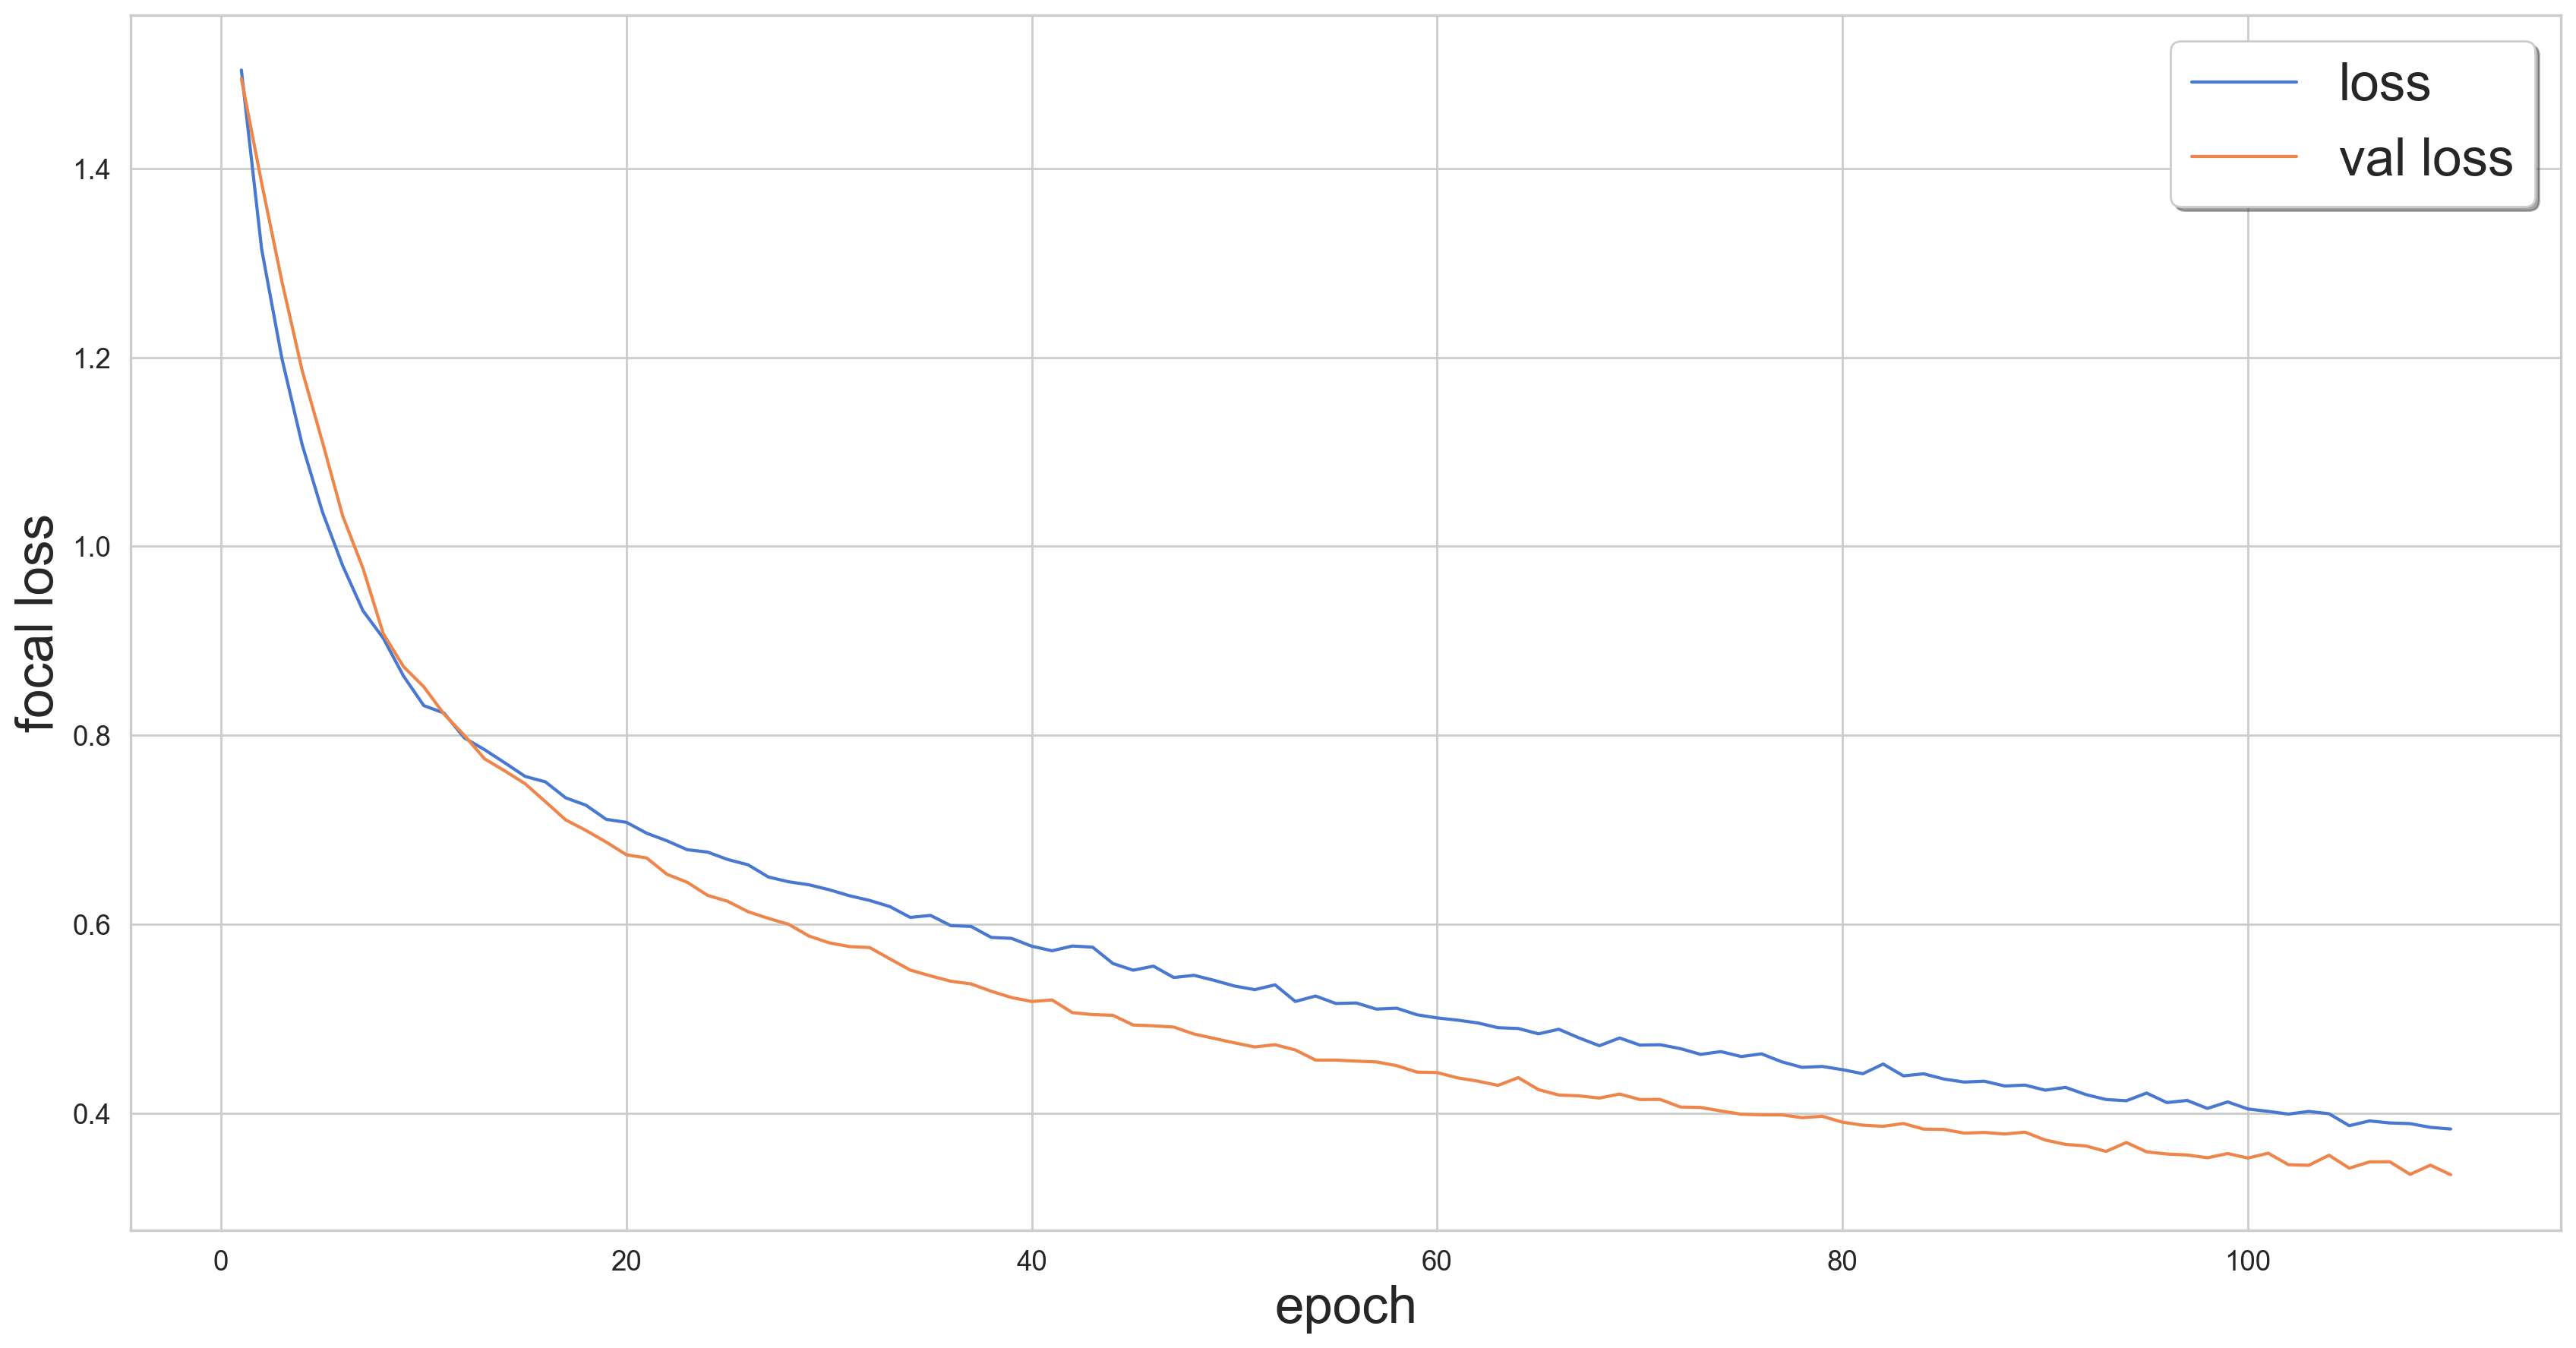

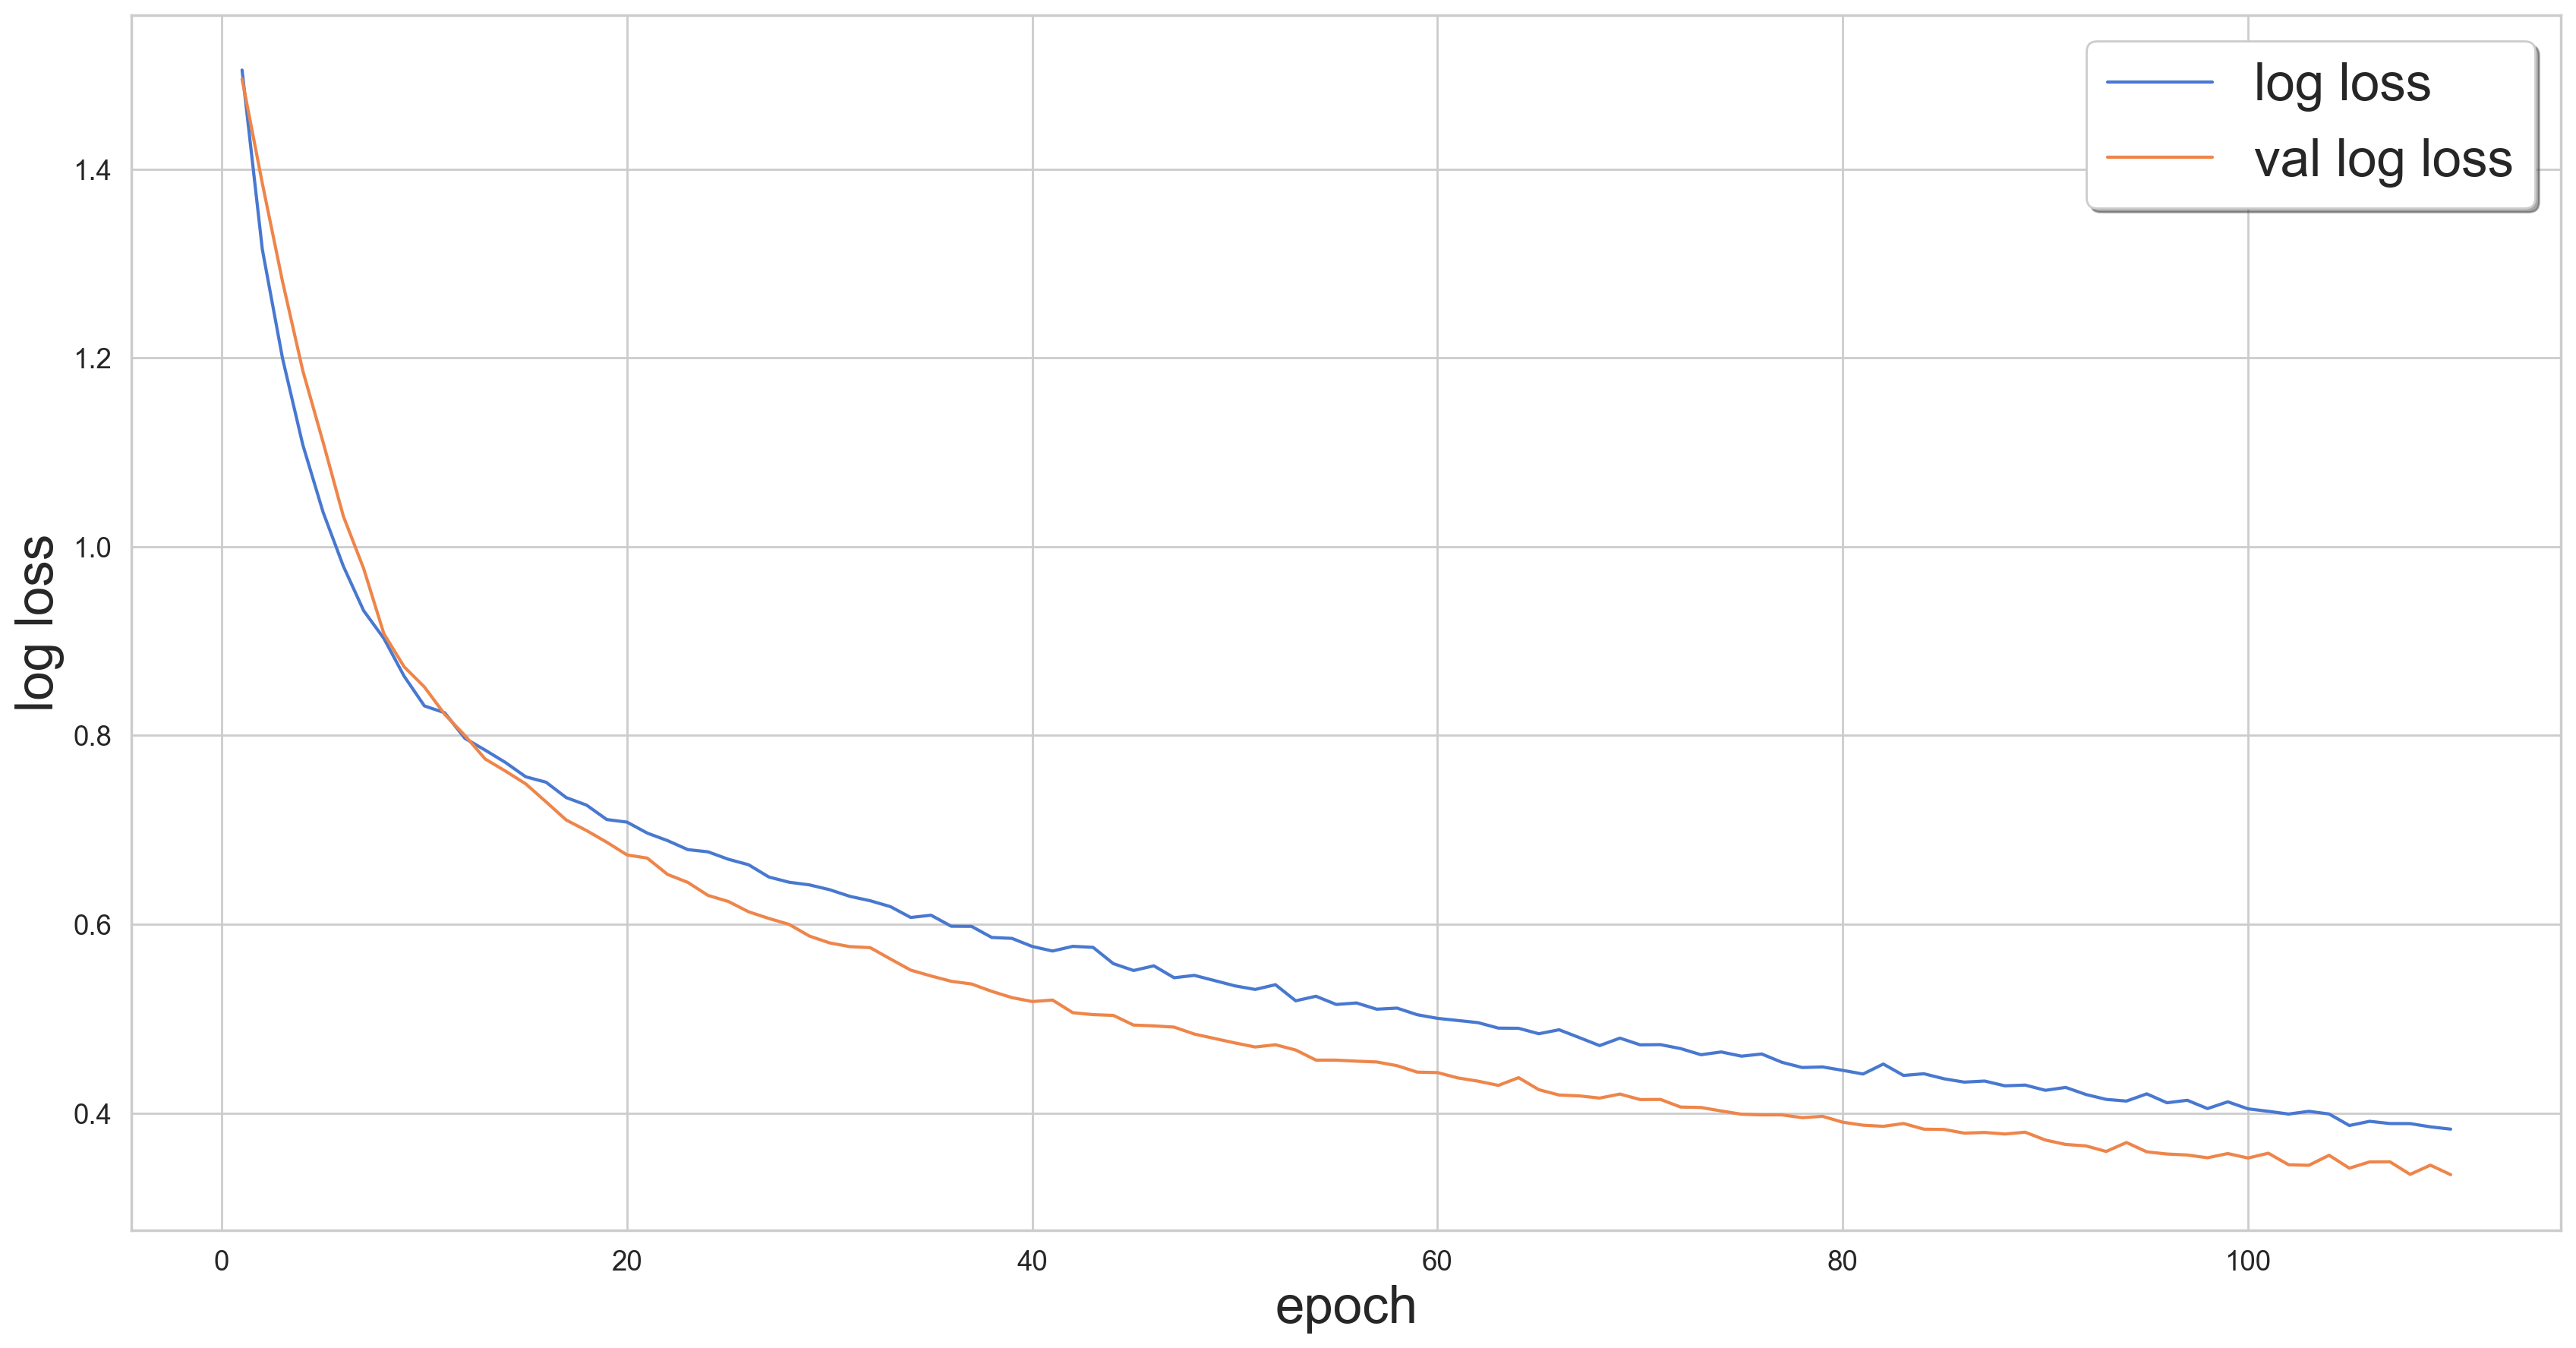

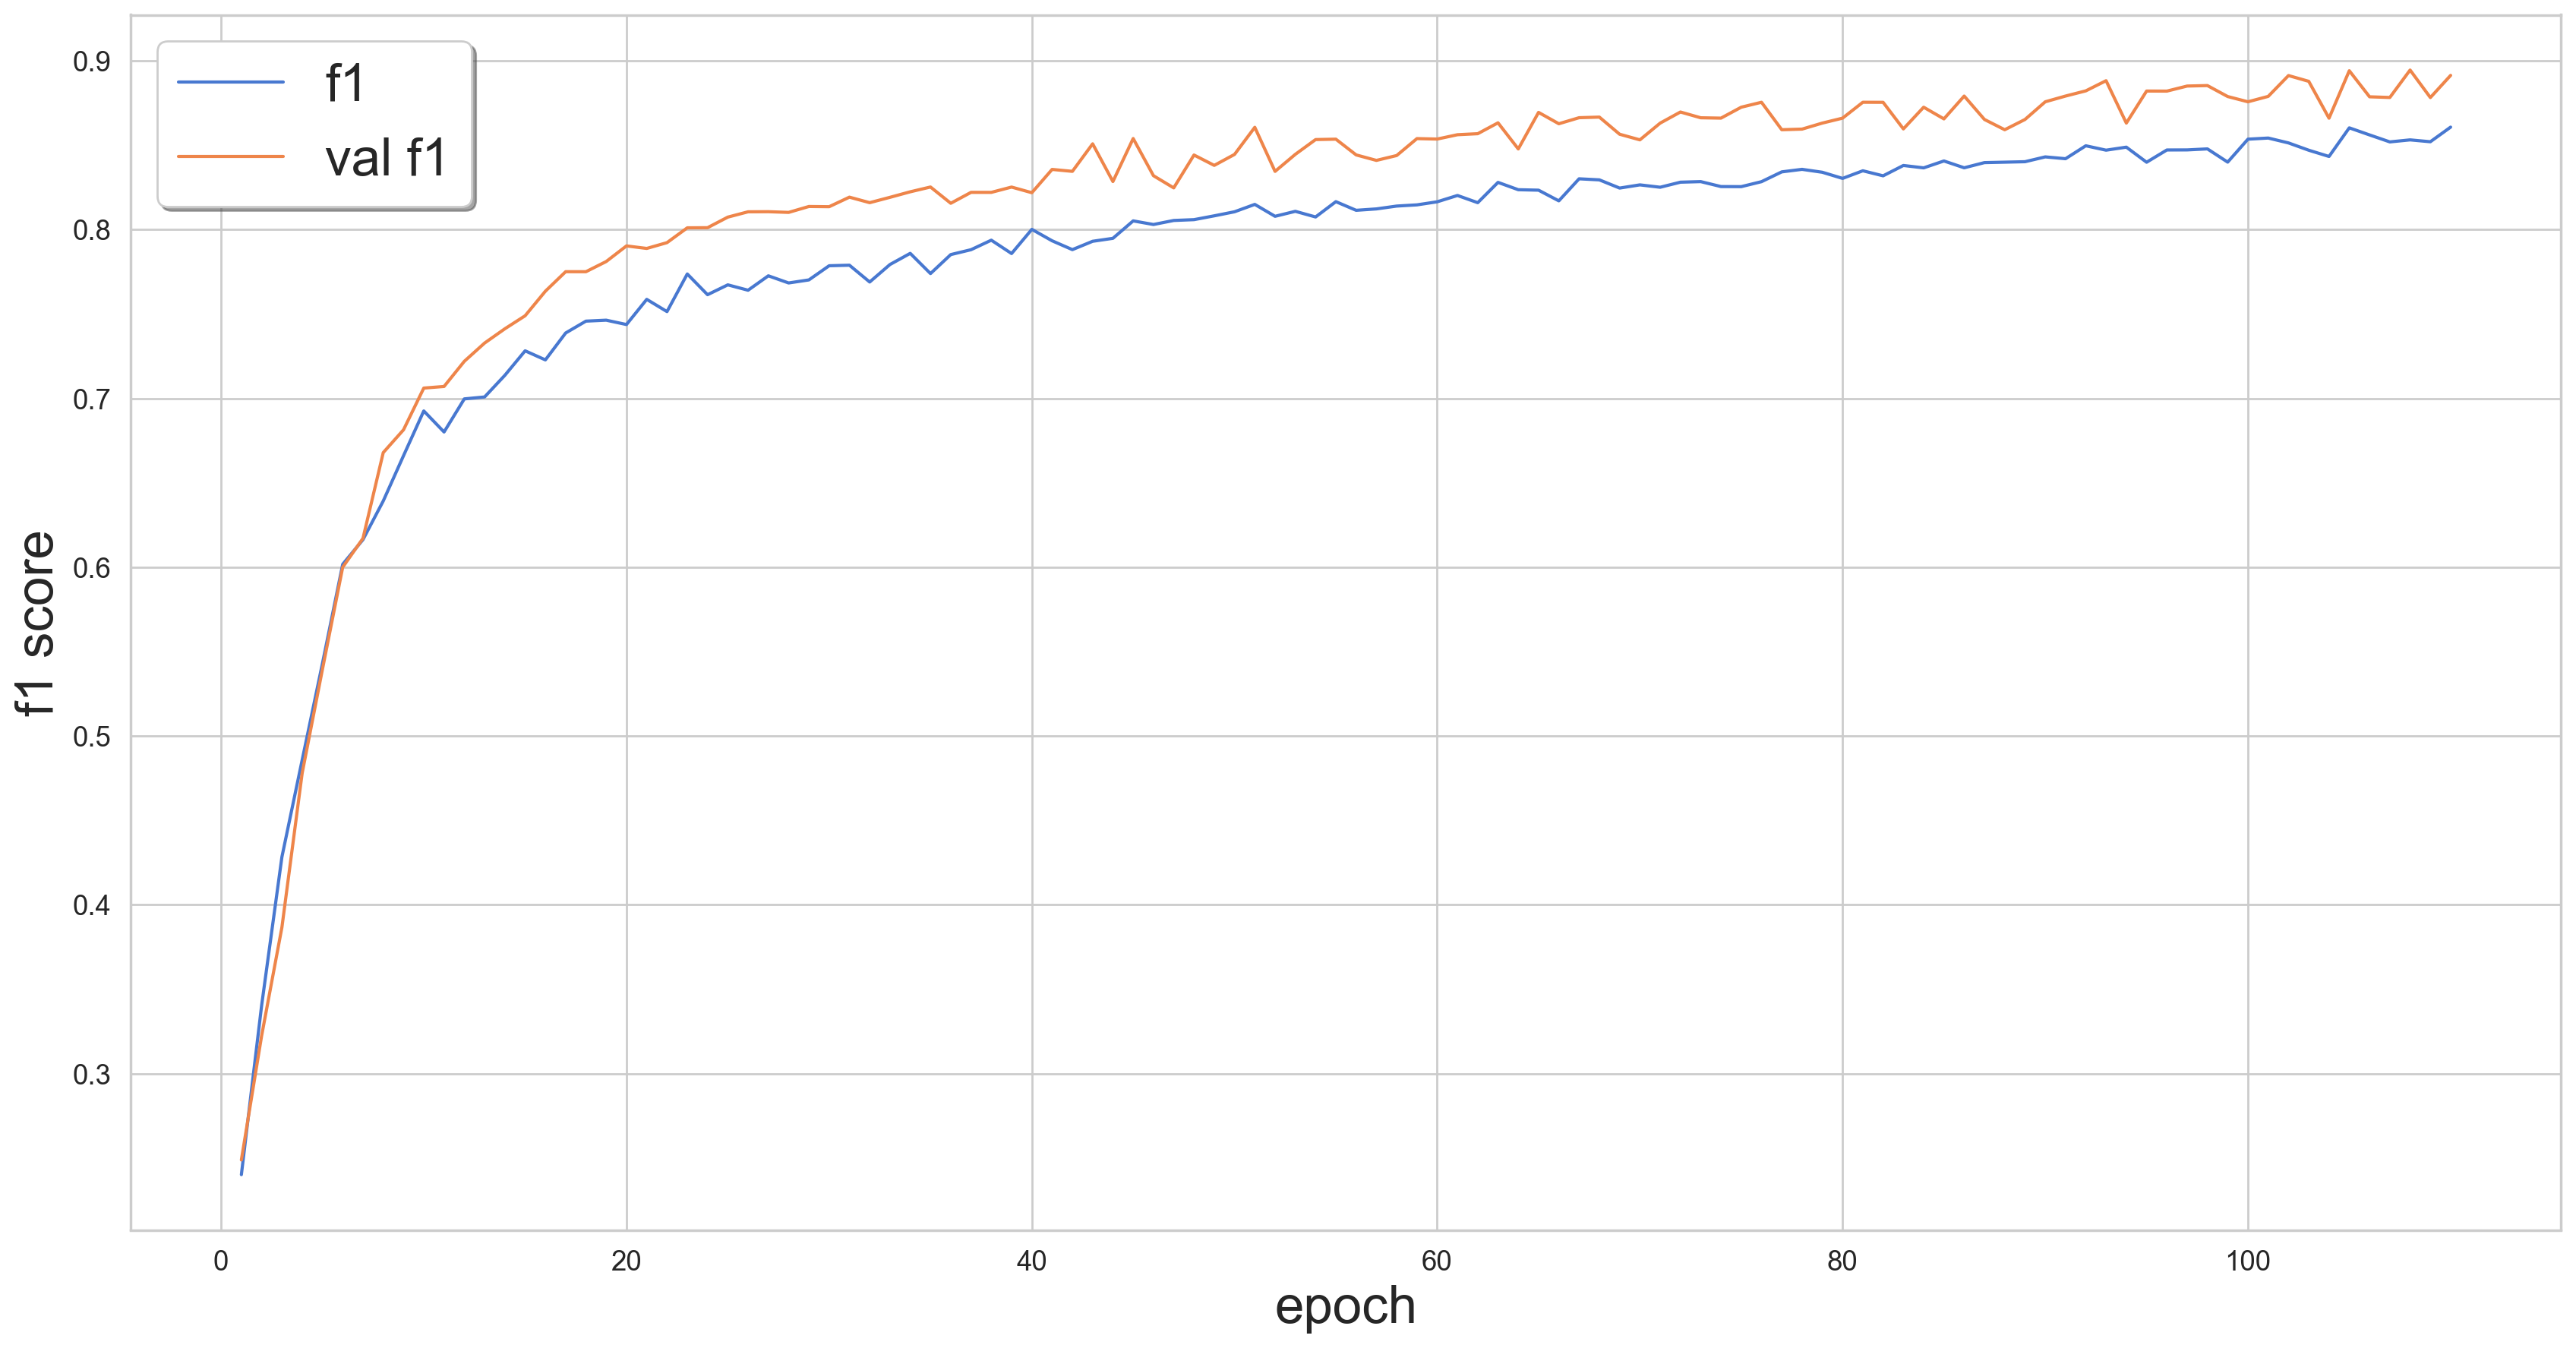

In [26]:
trainer.visualize_results()

### Testing

In [27]:
load_path= save_dir / "efficientnet-b0" / "efficientnet-b0.pth"

```Res18_config``` |  ```ENb0_config``` | ```MNv2_config``` | ```ENv2_config```

In [25]:
trainer.resume(load_path, ENb0_config, 1)

[*] Attempting to load model from: d:\Work\Extra\myanmar-weather-forecasting\src\traffic\models\models_runs\efficientnet-b0\efficientnet-b0.pth
[*] Initializing new efficientnet-b0 network...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_11116\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.37789674300067827 | val loss: 0.3416317939758301 | f1: 0.8577854844245897 | val f1: 0.8819369893194292 | log loss: 0.378117173910141 | val log loss: 0.34163182973861694


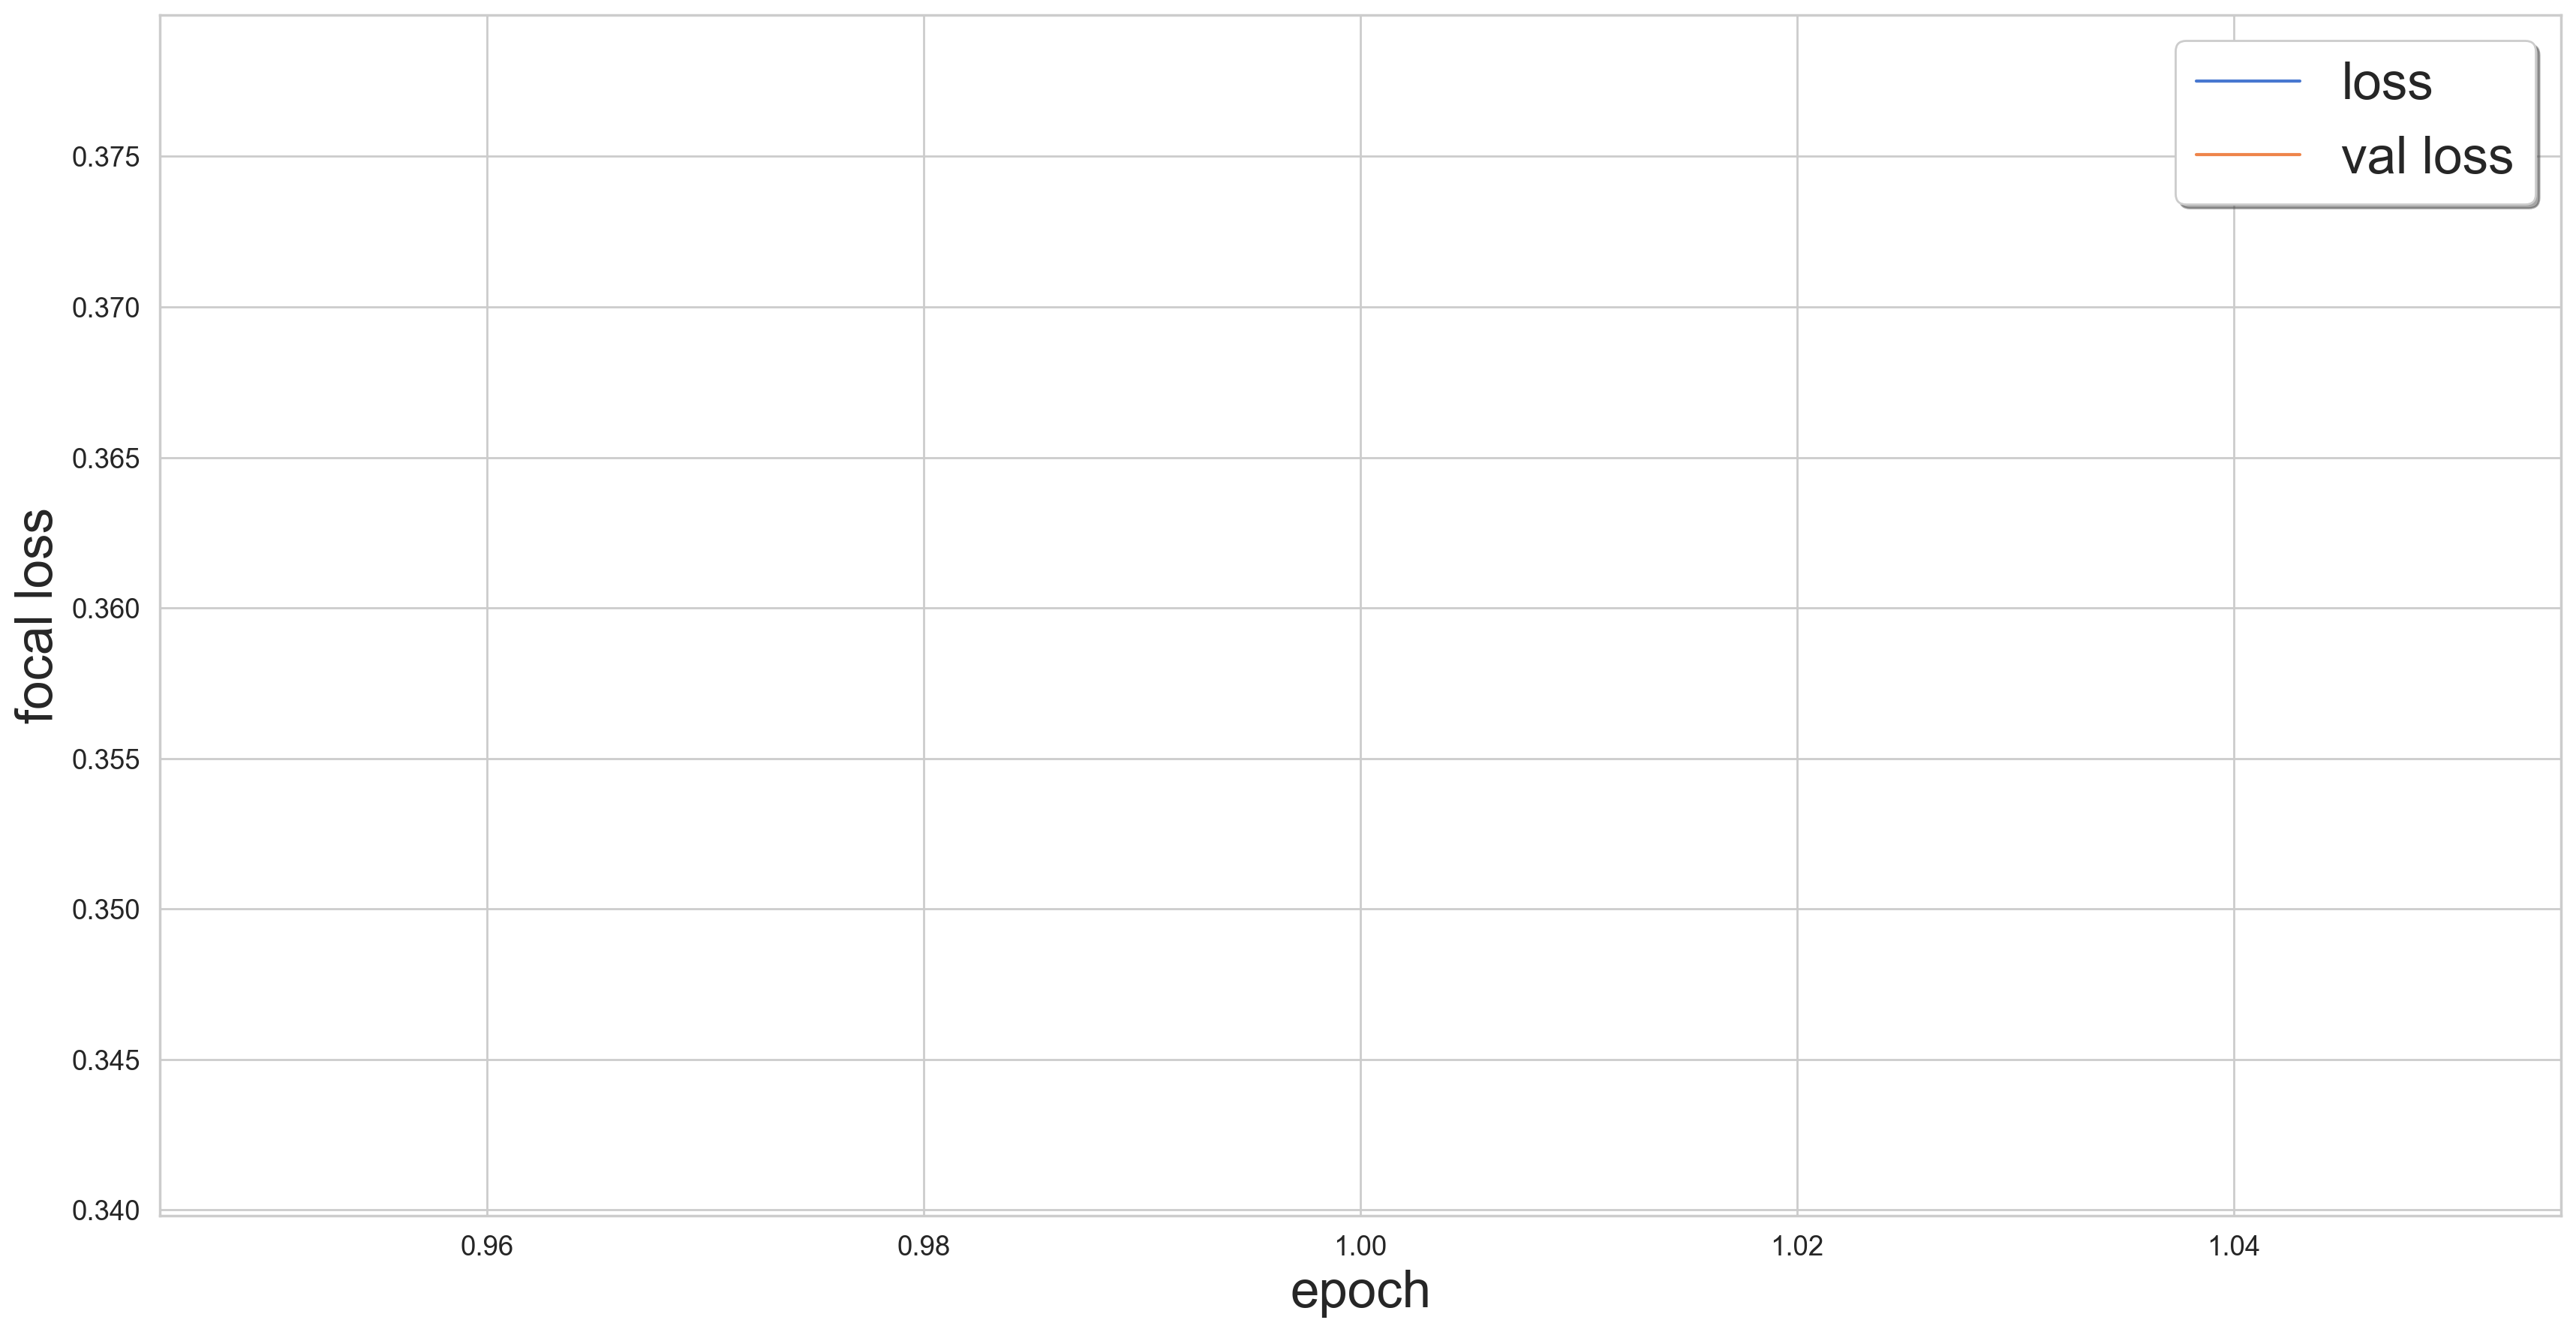

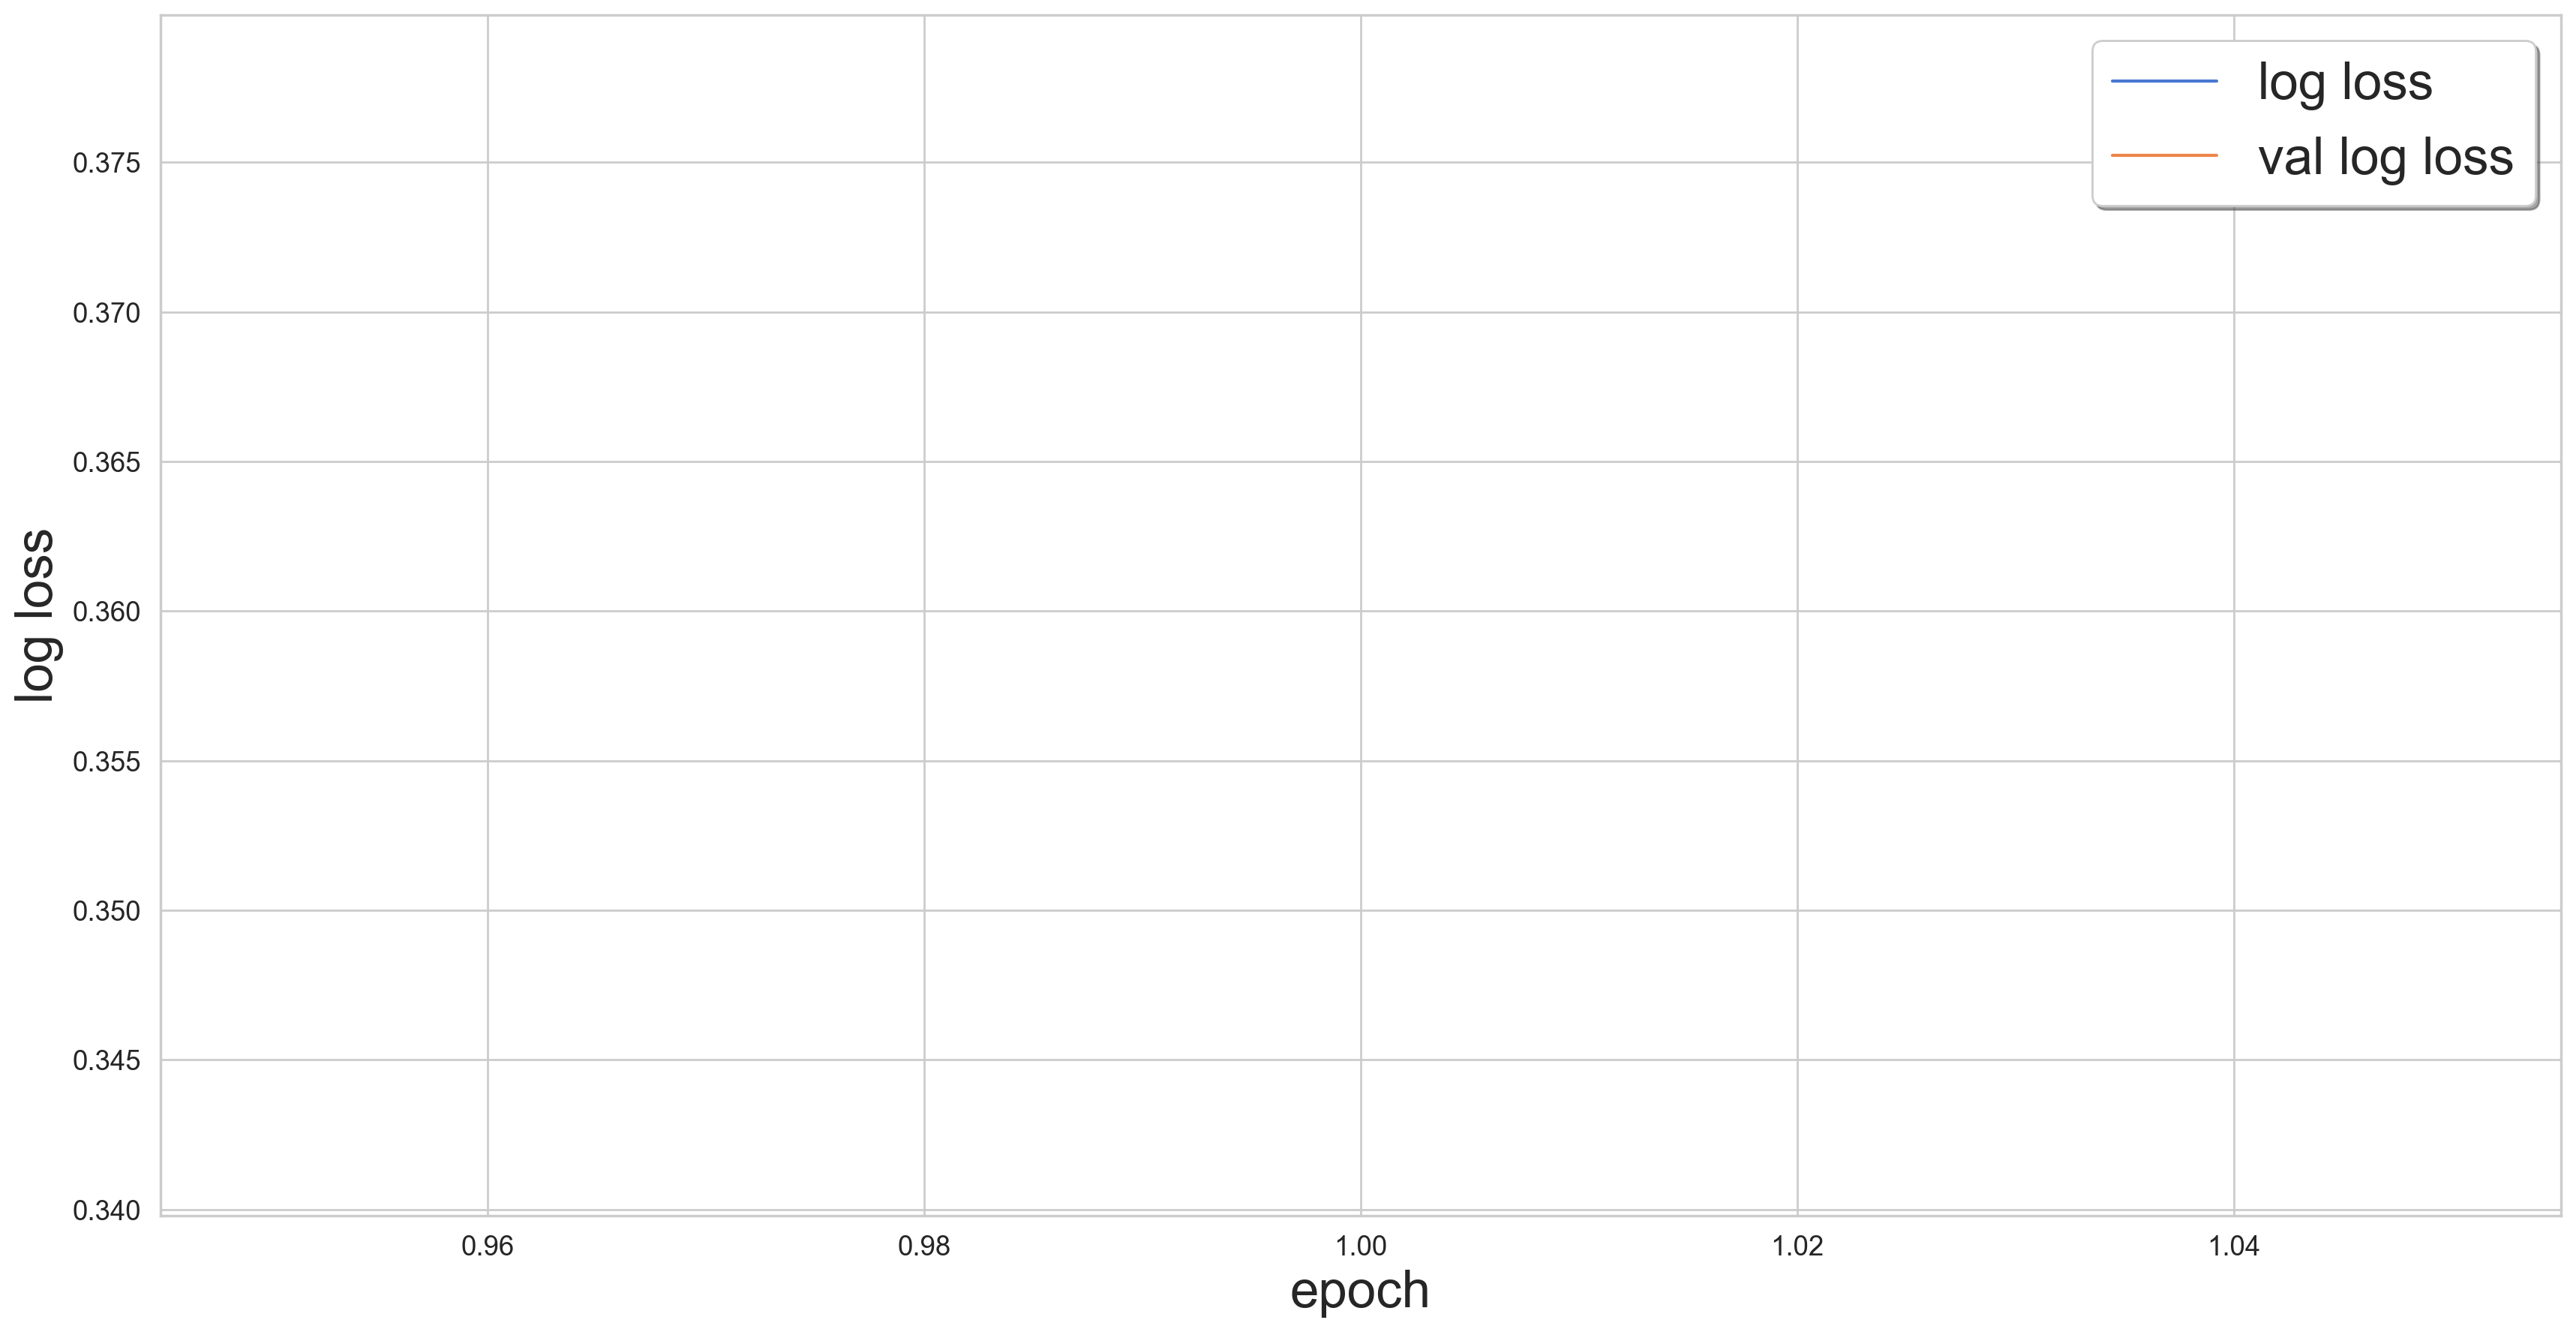

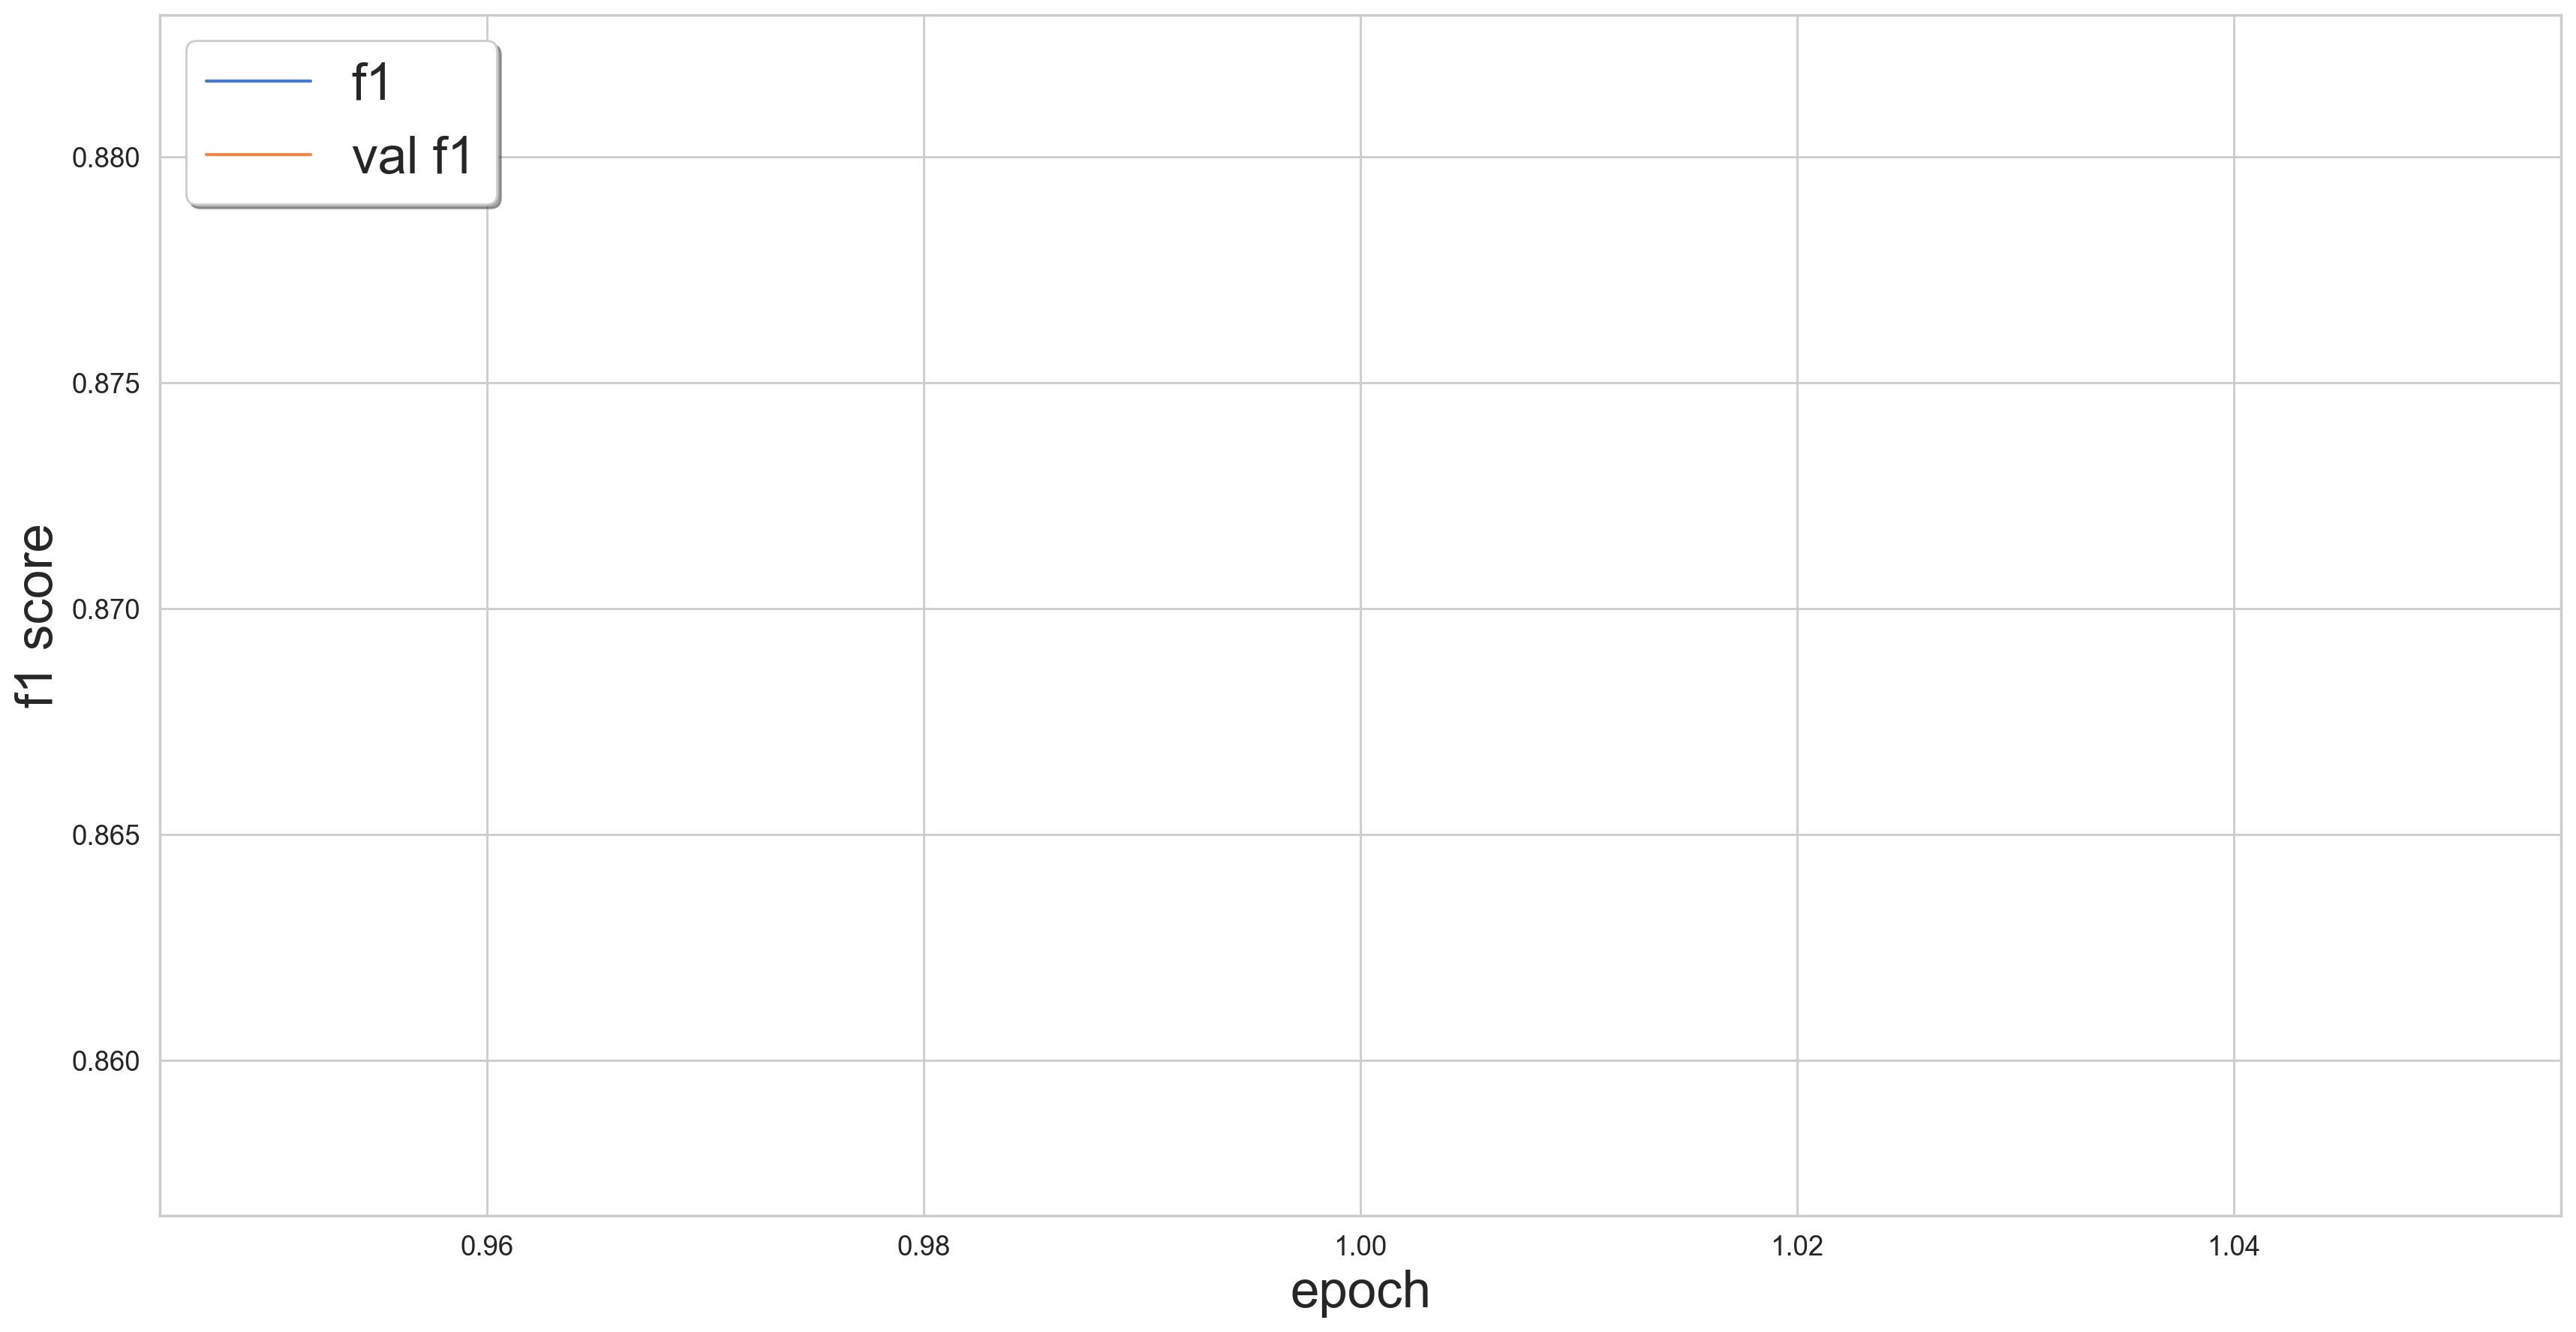

In [31]:
trainer.visualize_results()

In [28]:
loaded_model= TrafficClassifier(load_path= load_path, cfg=ENb0_config)

[*] Attempting to load model from: d:\Work\Extra\myanmar-weather-forecasting\src\traffic\models\models_runs\efficientnet-b0\efficientnet-b0.pth
[*] Initializing new efficientnet-b0 network...


c:\Users\AmrEl\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AmrEl\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
_, f1, _= loaded_model.test_model(test_dataloader)

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\AmrEl\AppData\Local\Temp\ipykernel_11116\2907849774.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


In [30]:
f1

0.8620597919940094

In [26]:
test_img= root_dir/"test"/"Low"/"6ae37c12-477a-4c52-9913-273d444db4a3.jpg"

In [27]:
loaded_model.inference(test_img)

'Low'

`Resnet18` F1: 0.8489117755918713 , 128 MB 

`ENb0` F1: 0.8620597919940094  , 47.1 MB
